Zaimportowanie potrzebnych bibliotek

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import itables

Wczytanie danych

In [79]:
df = pd.read_excel('dane_who.xlsx', sheet_name='AAP_2022_city_v9', header=0)


Biblioteka itables pozwala na interaktywne przeglądanie danych w formie tabeli, co daje dużą wygodę w zapoznaniu się z nimi przed przystąpieniem do ich dalszej analizy i preprocessingu.

In [58]:
itables.show(
    df,
    layout = {"top1":"searchPanes"},
    searchPanes = {"layout":"columns-3","cascadePanes":"True"}
)

Usunięcie nieprawidłowych wierszy - takich, w których wartości PM10 są mniejsze od PM2.5, ponieważ PM2.5 zawiera się w PM10, więc wartość nie może być większa.

In [80]:
wrong = df.loc[df['PM2.5 (μg/m3)'] > df['PM10 (μg/m3)']]
df = df.drop(wrong.index)
df.describe()


Measurement Year  PM2.5 (μg/m3)  PM10 (μg/m3)   NO2 (μg/m3)  \
count      32159.000000   15016.000000  21077.000000  22172.000000   
mean        2015.579154      22.922083     30.552164     20.625447   
std            2.752777      17.924199     29.326726     12.134387   
min         2000.000000       0.010000      1.040000      0.000000   
25%         2014.000000      10.350000     16.980000     12.000000   
50%         2016.000000      16.000000     22.010000     18.825000   
75%         2018.000000      31.010000     31.310000     27.162500   
max         2021.000000     191.900000    540.000000    210.680000   

       PM25 temporal coverage (%)  PM10 temporal coverage (%)  \
count                 7264.000000                 5367.000000   
mean                    90.803869                   90.598662   
std                     14.868841                   13.812023   
min                      0.000000                    2.568493   
25%                     88.630137                   87.980769   
50%                     97.000000                   96.062000   
75%                     99.000000                   98.938000   
max                    100.000000                  100.000000   

       NO2 temporal coverage (%)  Version of the database  Status  
count               19865.000000              32159.00000     0.0  
mean                   93.700603               2021.74396     NaN  
std                    10.448658                  1.05239     NaN  
min                     1.923077               2016.00000     NaN  
25%                    93.207763               2022.00000     NaN  
50%                    96.369863               2022.00000     NaN  
75%                    98.926941               2022.00000     NaN  
max                   100.000000               2022.00000     NaN

Uzupełnienie wartości NaN dla Regionów - Liechtenstein został przypisany do Europy.

In [81]:
print(df['WHO Region'].unique())
display(df[df['WHO Region'].isna()])
df.loc[df['WHO Country Name'] == 'Liechtenstein', 'WHO Region'] = 'European Region'


['Eastern Mediterranean Region' 'European Region' 'Region of the Americas'
 'Western Pacific Region' 'South East Asia Region' 'African Region' nan]


WHO Region ISO3 WHO Country Name City or Locality  Measurement Year  \
24778        NaN  LIE    Liechtenstein            Vaduz              2010   

       PM2.5 (μg/m3)  PM10 (μg/m3)  NO2 (μg/m3)  PM25 temporal coverage (%)  \
24778            NaN         17.88        23.59                         NaN   

       PM10 temporal coverage (%)  NO2 temporal coverage (%)  \
24778                      96.164                     98.265   

                                               Reference  \
24778  European Environment Information and Observati...   

      Number and type of monitoring stations  Version of the database  Status  
24778                                    NaN                     2022     NaN

Sprawdzenie liczby wartości w kolumnach

In [102]:
print(df.count())

WHO Region                                32159
ISO3                                      32159
WHO Country Name                          32159
City or Locality                          32159
Measurement Year                          32159
PM2.5 (μg/m3)                             15016
PM10 (μg/m3)                              21077
NO2 (μg/m3)                               22172
PM25 temporal coverage (%)                 7264
PM10 temporal coverage (%)                 5367
NO2 temporal coverage (%)                 19865
Reference                                 32154
Number and type of monitoring stations     8745
Version of the database                   32159
Status                                        0
dtype: int64


Stworzenie osobnych ramek danych dla każdego regionu

In [82]:
regions = df['WHO Region'].unique()
dataframes = []
for region in regions:
    name_df = f"df_{region.replace(' ', '')}"
    exec(f"{name_df} = df[df['WHO Region'] == '{region}']")
    dataframes.append(name_df)

Rozkład wartości zanieczyszczeń dla każdego regionu

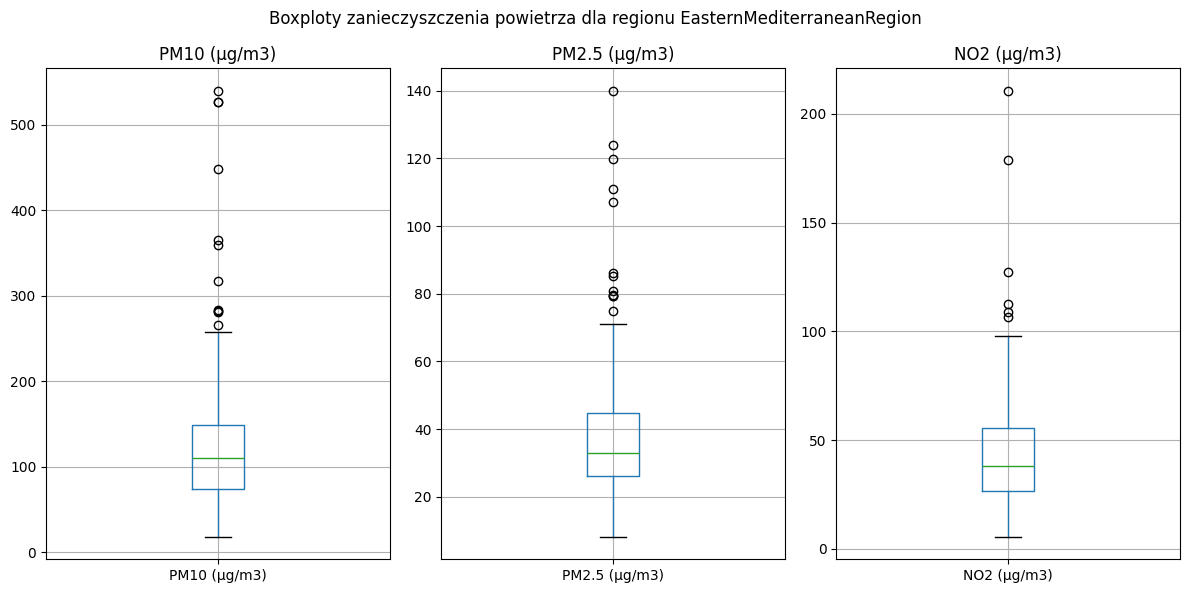

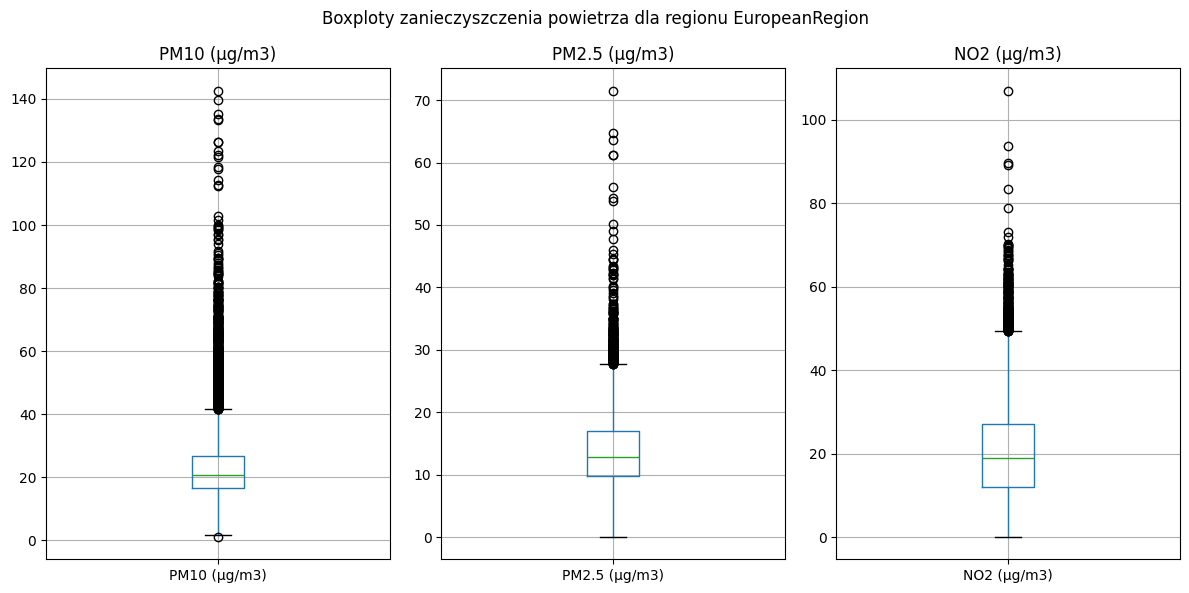

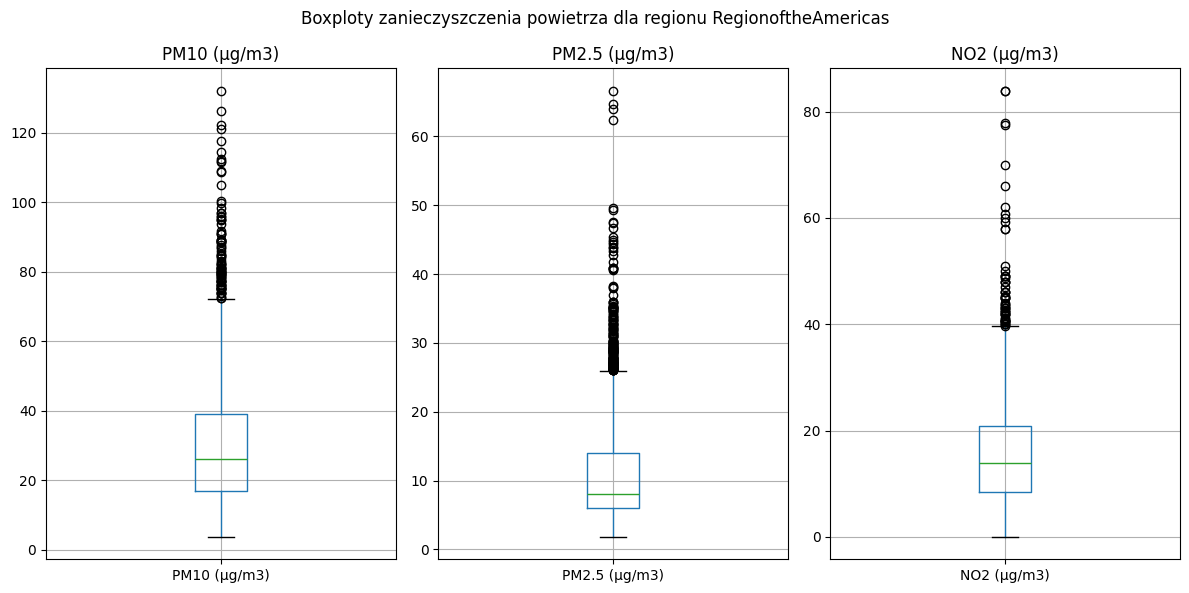

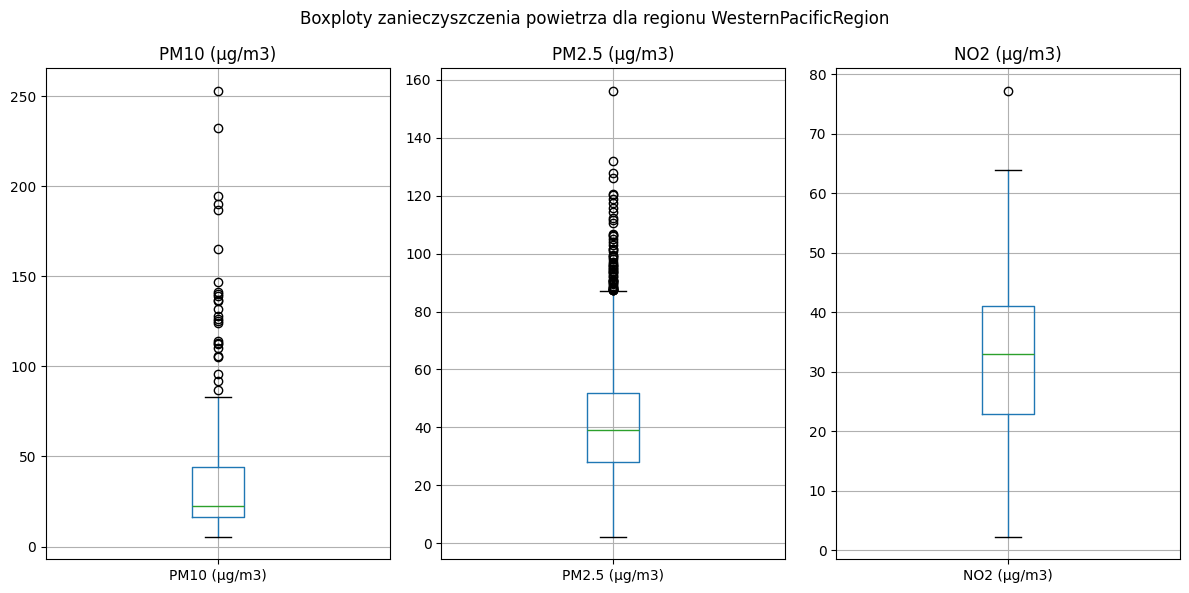

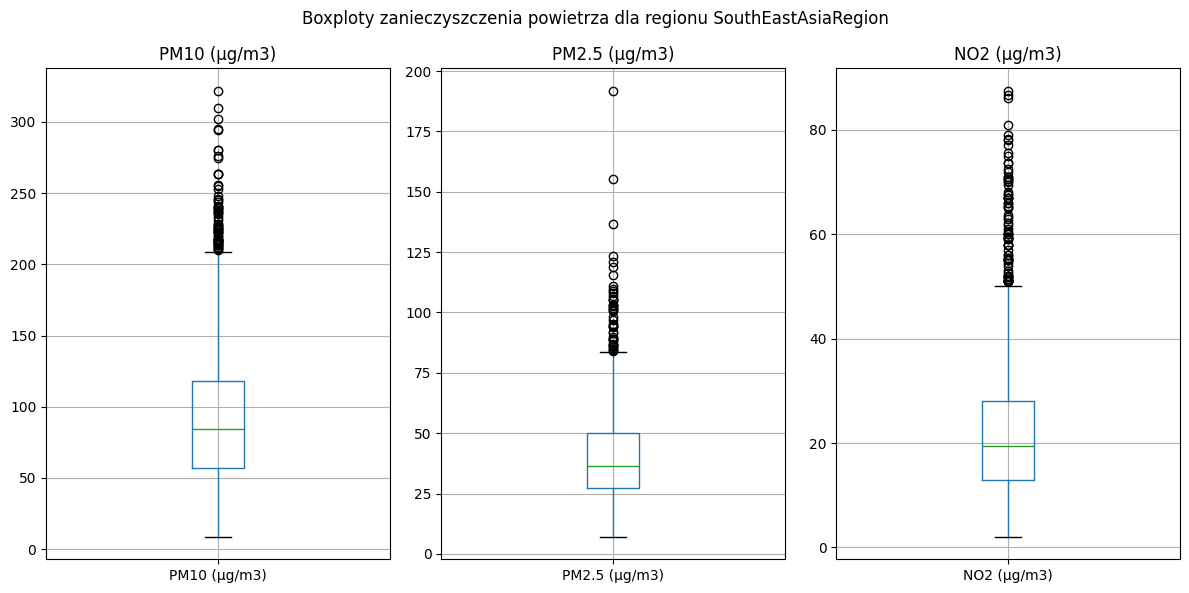

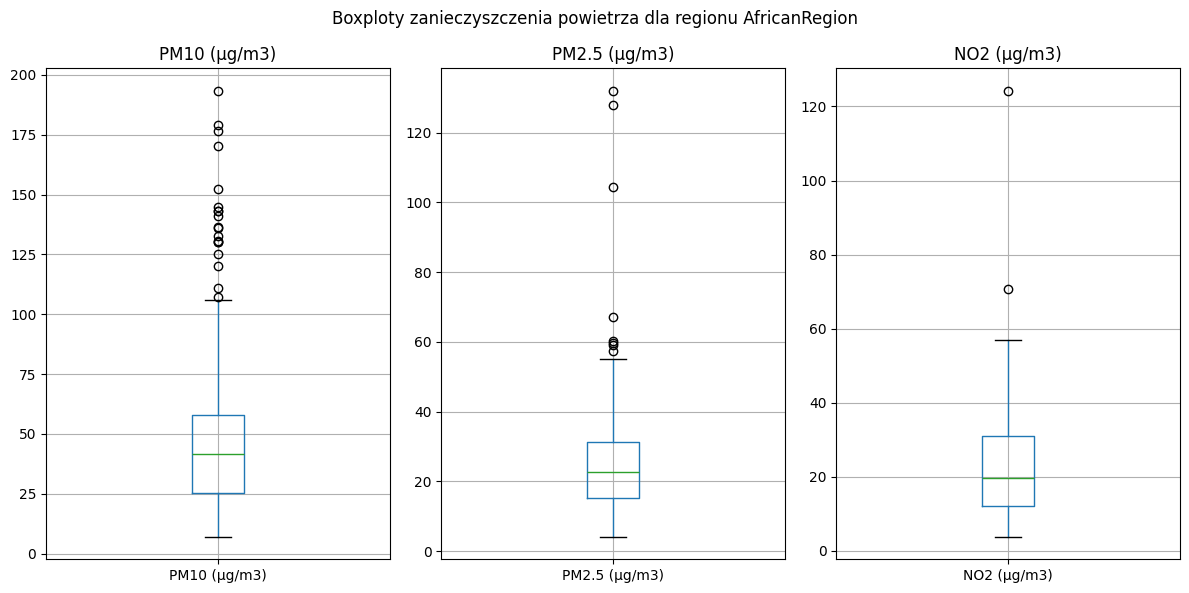

In [69]:
for df_name in dataframes:
    df_region = eval(df_name)

    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Boxploty zanieczyszczenia powietrza dla regionu {df_name[3:]}')
    plt.subplot(1, 3, 1)
    df_region.boxplot(column='PM10 (μg/m3)')
    plt.title(f'PM10 (μg/m3)')
    plt.subplot(1, 3, 2)
    df_region.boxplot(column='PM2.5 (μg/m3)')
    plt.title(f'PM2.5 (μg/m3)')
    plt.subplot(1, 3, 3)
    df_region.boxplot(column='NO2 (μg/m3)')
    plt.title(f'NO2 (μg/m3)')
    plt.tight_layout()
    plt.show()

Stworzenie osobnych ramek danych dla każdego regionu

Wizualizacja średniego poziomu zanieczyszczeń

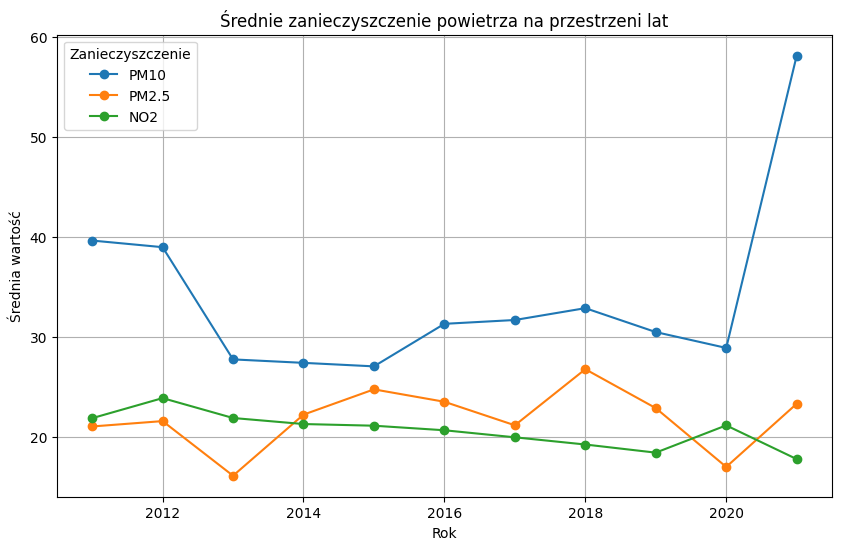

In [6]:
df_mean_PM10 = df[df['Measurement Year'] > 2010].groupby('Measurement Year')['PM10 (μg/m3)'].mean()
df_mean_PM2_5 = df[df['Measurement Year'] > 2010].groupby('Measurement Year')['PM2.5 (μg/m3)'].mean()
df_mean_NO2 = df[df['Measurement Year'] > 2010].groupby('Measurement Year')['NO2 (μg/m3)'].mean()

plt.figure(figsize=(10, 6))

plt.plot(df_mean_PM10.index, df_mean_PM10.values, label='PM10',marker='o')
plt.plot(df_mean_PM2_5.index, df_mean_PM2_5.values, label='PM2.5',marker='o')
plt.plot(df_mean_NO2.index, df_mean_NO2.values, label='NO2',marker='o')

plt.title('Średnie zanieczyszczenie powietrza na przestrzeni lat')
plt.xlabel('Rok')
plt.ylabel('Średnia wartość')
plt.grid(True)
plt.legend(title='Zanieczyszczenie')
plt.show()

Można zaobserwować nagły, gwałtowny wzrost wartości PM10 od 2020 roku, który odbiega mocno od wzrostu PM2.5. Jest to zastanawiające zjawisko, ponieważ mogłoby się wydawać, że świadomość dotycząca jakości powietrza rośnie, więc wartości powinny mieć tendencję bardziej spadkową lub utrzymującą się. W dalszych krokach zostanie to zbadane. Do stworzenia wykresu zostały wykorzystane lata po 2010 roku, ponieważ dla wcześniejszych lat dane pochodziły tylko z jednego miejsca - Bahrain i ich wizualizacja nie byłaby miarodajna, dlatego już na wstępie nie były brane pod uwagę.

In [62]:
display(df[df["Measurement Year"] < 2010].groupby(["WHO Country Name", "Measurement Year"]).count())

WHO Region  ISO3  City or Locality  \
WHO Country Name Measurement Year                                       
Bahrain          2000                       3     3                 3   
                 2001                       3     3                 3   
                 2002                       3     3                 3   
                 2003                       2     2                 2   
                 2004                       2     2                 2   
                 2006                       3     3                 3   
                 2007                       3     3                 3   
                 2008                       1     1                 1   
                 2009                       1     1                 1   

                                   PM2.5 (μg/m3)  PM10 (μg/m3)  NO2 (μg/m3)  \
WHO Country Name Measurement Year                                             
Bahrain          2000                          0             3            0   
                 2001                          0             3            0   
                 2002                          0             3            0   
                 2003                          0             2            0   
                 2004                          0             2            0   
                 2006                          0             3            0   
                 2007                          0             3            0   
                 2008                          0             1            0   
                 2009                          0             1            0   

                                   PM25 temporal coverage (%)  \
WHO Country Name Measurement Year                               
Bahrain          2000                                       0   
                 2001                                       0   
                 2002                                       0   
                 2003                                       0   
                 2004                                       0   
                 2006                                       0   
                 2007                                       0   
                 2008                                       0   
                 2009                                       0   

                                   PM10 temporal coverage (%)  \
WHO Country Name Measurement Year                               
Bahrain          2000                                       0   
                 2001                                       0   
                 2002                                       0   
                 2003                                       0   
                 2004                                       0   
                 2006                                       0   
                 2007                                       0   
                 2008                                       0   
                 2009                                       0   

                                   NO2 temporal coverage (%)  Reference  \
WHO Country Name Measurement Year                                         
Bahrain          2000                                      0          3   
                 2001                                      0          3   
                 2002                                      0          3   
                 2003                                      0          2   
                 2004                                      0          2   
                 2006                                      0          3   
                 2007                                      0          3   
                 2008                                      0          1   
                 2009                                      0          1   

                                   Number and type of monitoring stations  \
WHO Country Name Measureme

Wykresy poziomu zanieczyszczeń dla każdego regionu

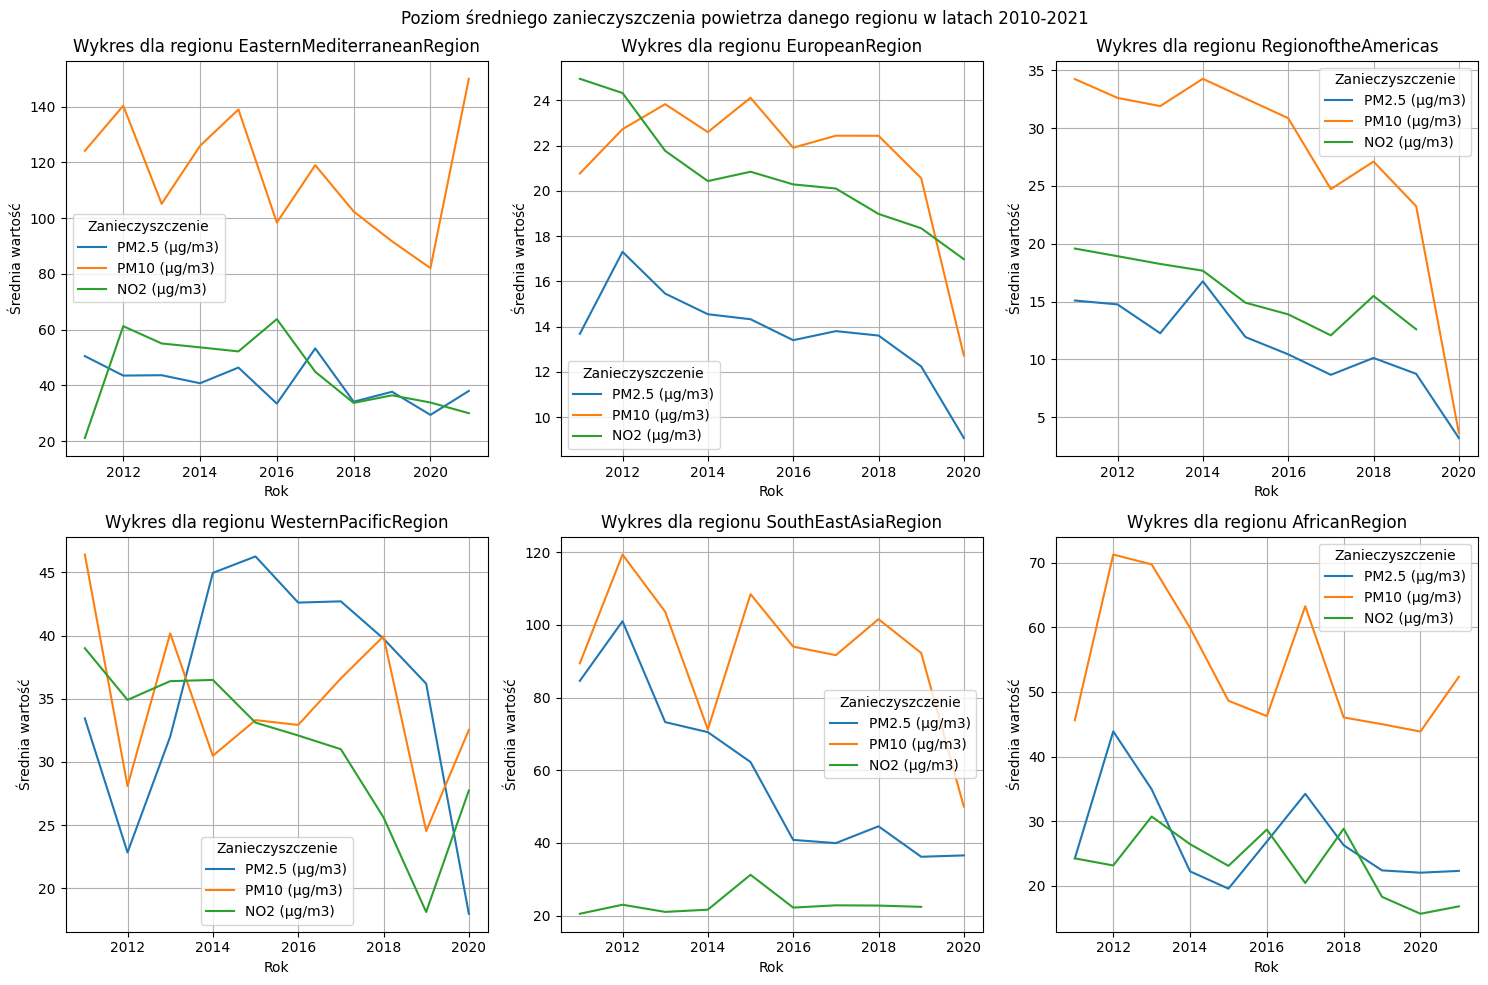

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, df_name in enumerate(dataframes):
    dfi = eval(df_name) 
    df_mean = dfi[dfi['Measurement Year'] > 2010].groupby('Measurement Year')[['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']].mean()
    row = i // 3
    col = i % 3
    df_mean.plot(kind='line', ax=axs[row, col])
    
    axs[row, col].set_title(f'Wykres dla regionu {df_name[3:]}')
    axs[row, col].set_xlabel('Rok')
    axs[row, col].set_ylabel('Średnia wartość')
    axs[row, col].grid(True)
    axs[row, col].legend(title='Zanieczyszczenie')

fig.suptitle("Poziom średniego zanieczyszczenia powietrza danego regionu w latach 2010-2021")
plt.tight_layout()
plt.show()

Możemy zauważyć, że w bardziej rozwiniętych regionach, z większą świadomością ekologiczną poziom średnich zanieczyszczeń zmniejsza się. Warto zwrócić uwagę też na skalę wykresów - Europa oraz Ameryki w najmniejszym stopniu odpowiadają za zanieczyszczenia powietrza. Za to bardzo duże wartości pojawiają się dla okolic półwyspu arabskiego, może mieć to związek z wydobyciem ropy naftowej na tych terenach, innymi działalnościami przemysłowymi, transportem, a także warunkami naturalnymi. Możemy też już zobaczyć skąd wynika gwałtowny wzrost wartości PM10 na poprzednim wykresie - dla tylko dwóch regionów wykresy przedstawiają wartości po 2020 roku, na dodatek są to regiony z bardzo zanieczyszczonym powietrzem. Przyjrzyjmy się jak poszczególne kraje przyczyniają się do poziomu zanieczyszczeń.

Wykresy poziomu zanieczyszczeń krajów w danym regionie 

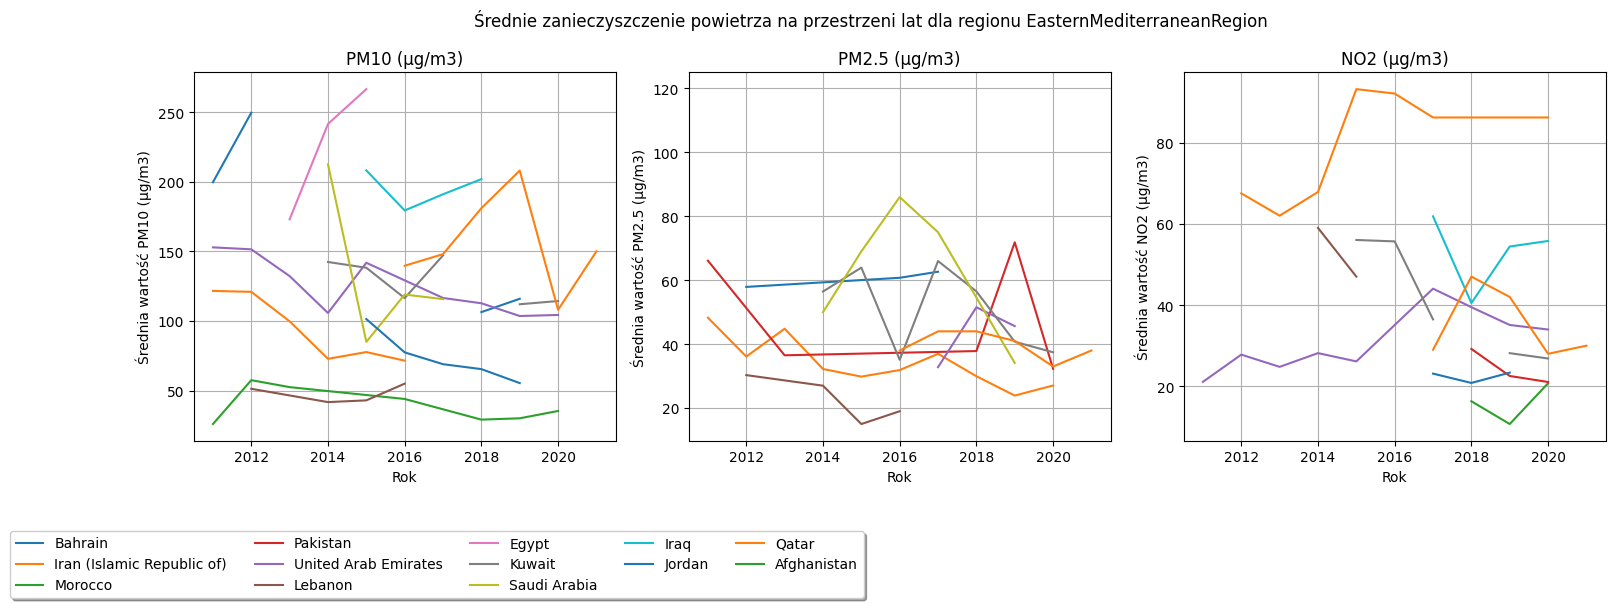

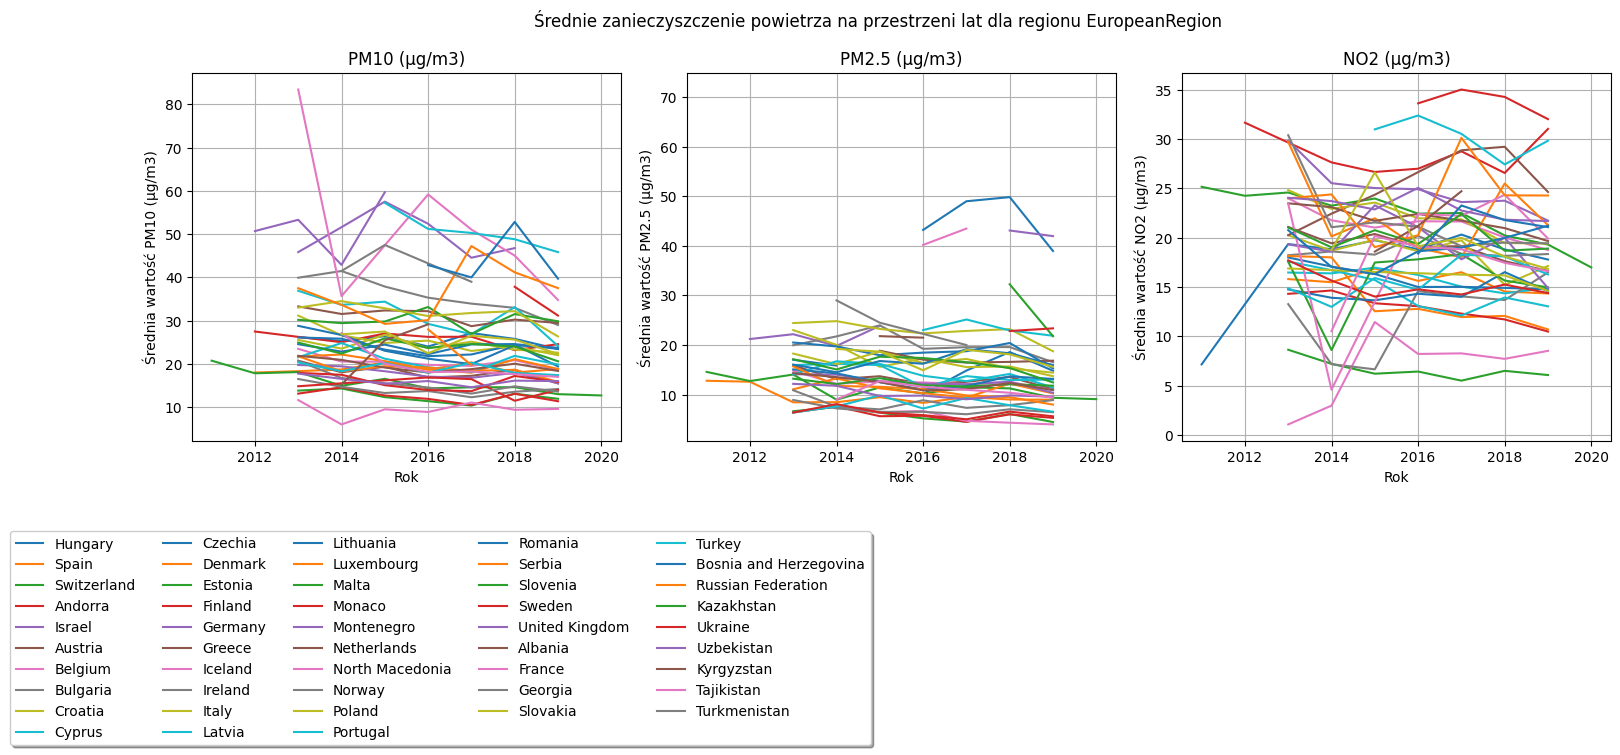

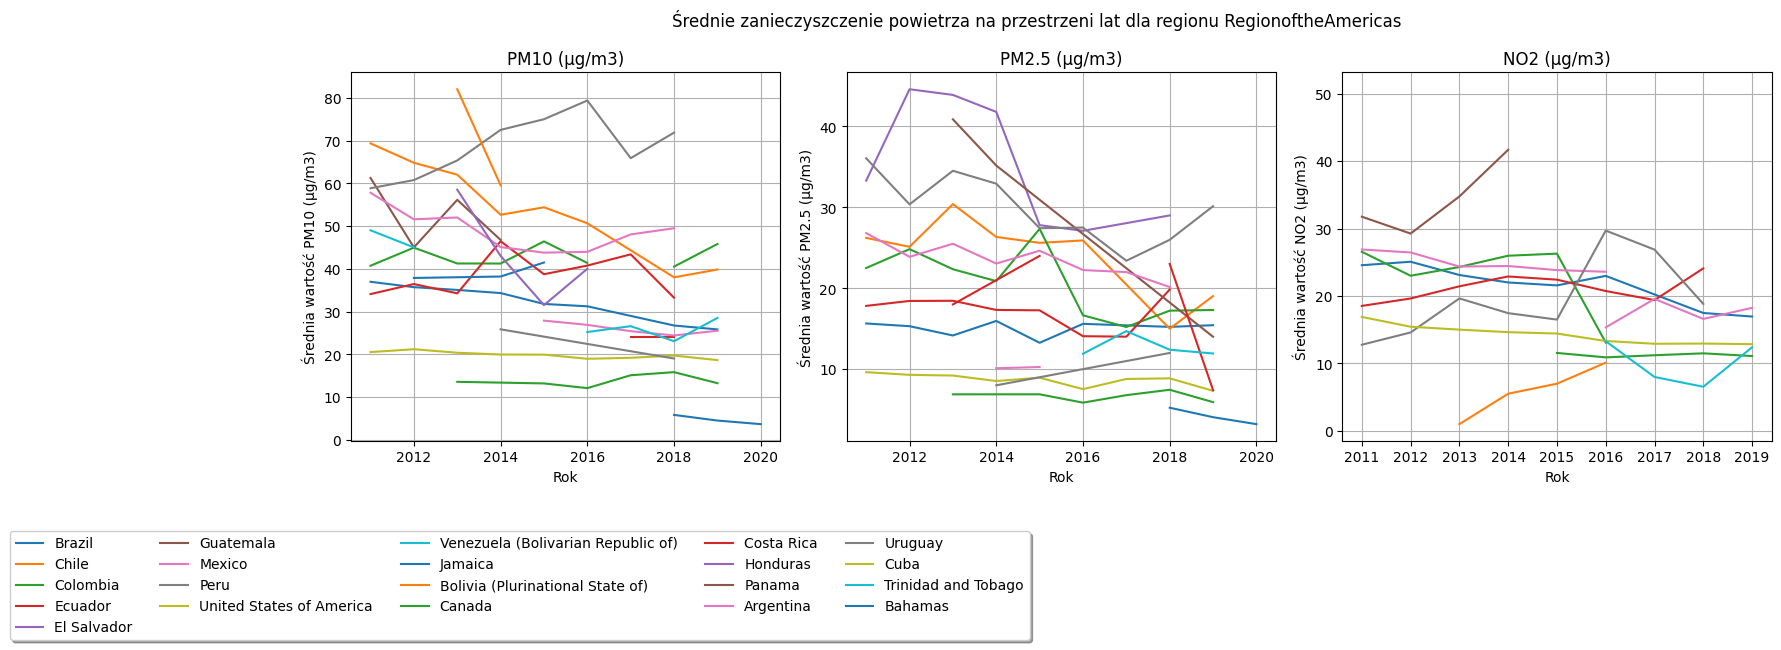

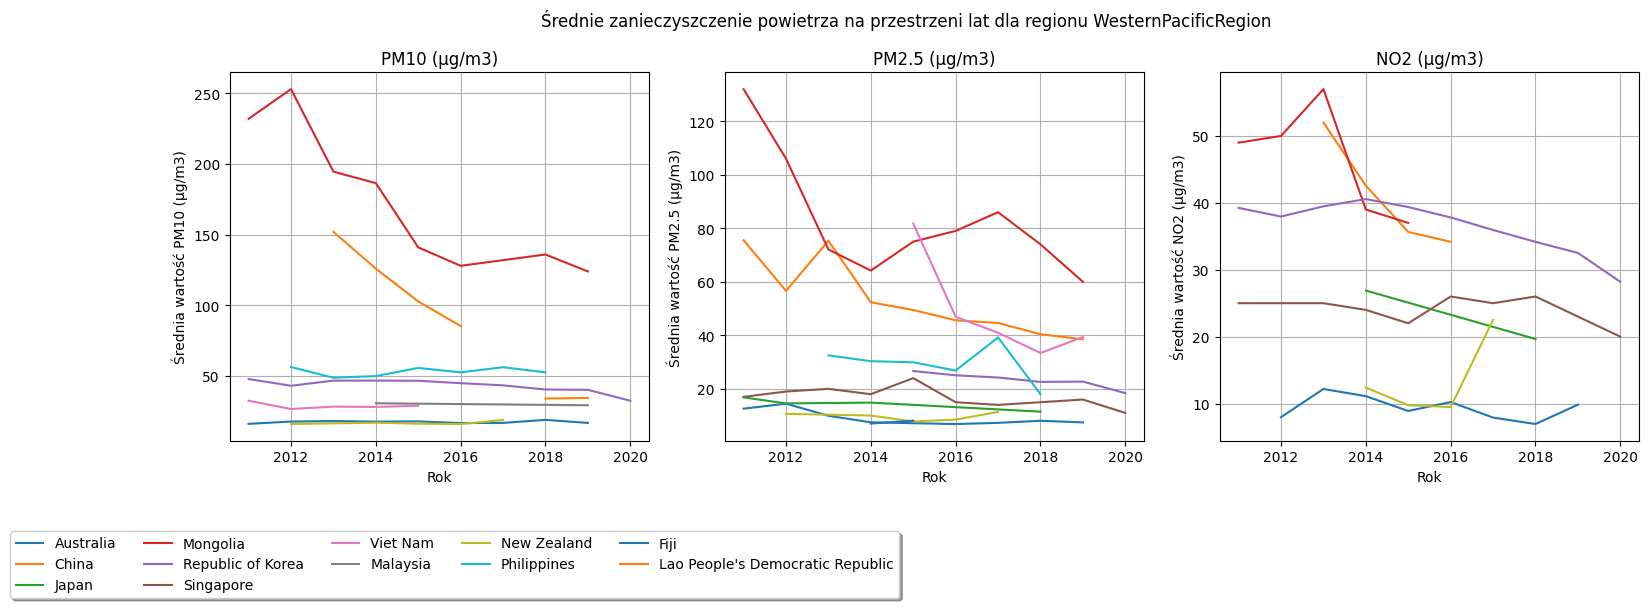

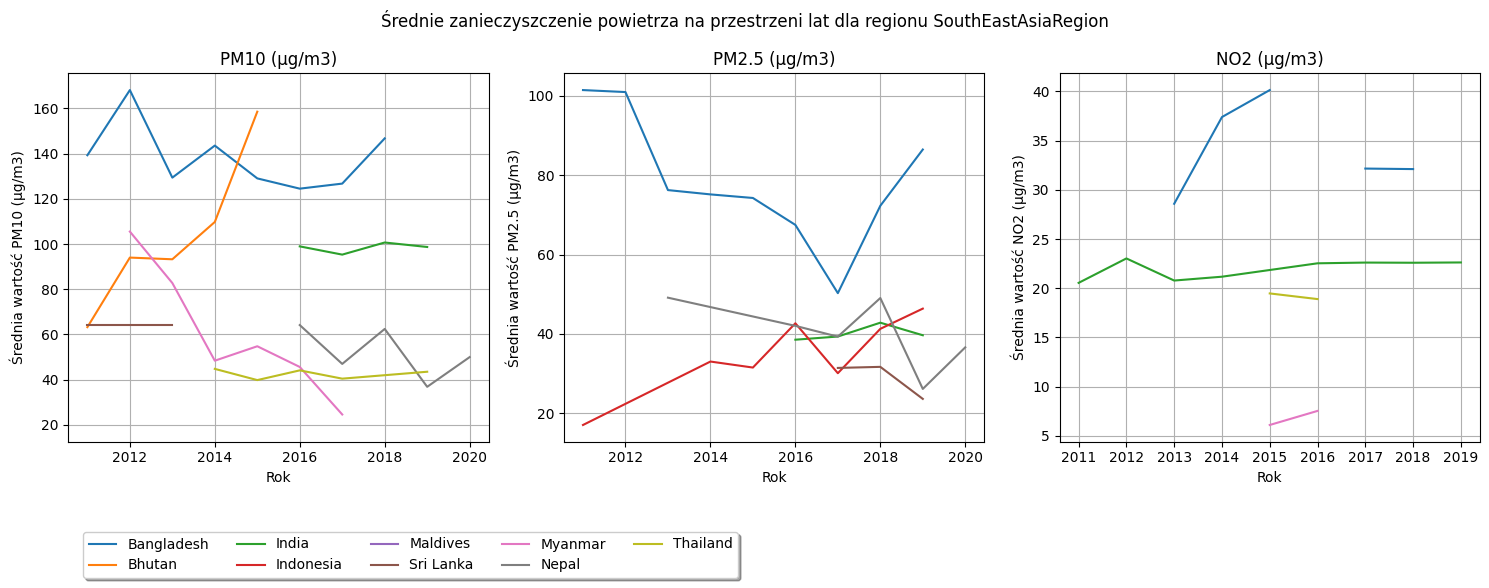

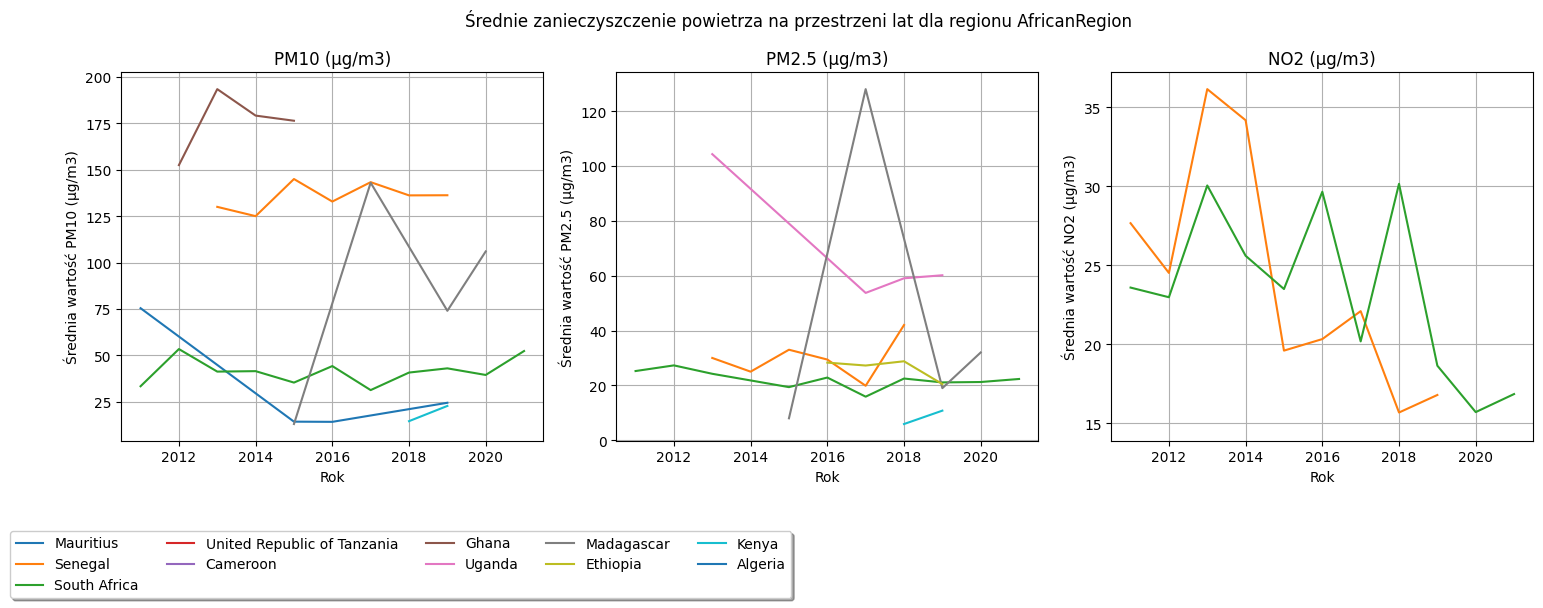

In [8]:

for df_name in dataframes:
    dfi = eval(df_name) 
    df_mean = dfi[dfi['Measurement Year'] > 2010].groupby(['Measurement Year', 'WHO Country Name'])[['PM10 (μg/m3)', 'PM2.5 (μg/m3)', 'NO2 (μg/m3)']].mean()
    df_mean.reset_index(inplace=True)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for i, pollutant in enumerate(['PM10 (μg/m3)', 'PM2.5 (μg/m3)', 'NO2 (μg/m3)']):
        for country in df_mean['WHO Country Name'].unique():
            df_country = df_mean[df_mean['WHO Country Name'] == country]
            axs[i].plot(df_country['Measurement Year'], df_country[pollutant], label=country)

        axs[i].set_title(pollutant)
        axs[i].set_xlabel('Rok')
        axs[i].set_ylabel(f'Średnia wartość {pollutant}')
        axs[i].grid(True)

    fig.suptitle(f'Średnie zanieczyszczenie powietrza na przestrzeni lat dla regionu {df_name[3:]}')
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

    plt.tight_layout()
    plt.show()

Na tych wykresach jeszcze wyraźniej widać, skąd wziął się ten gwałtowny wzrost po 2020 roku - tylko dwa kraje były brane pod uwagę. Dla wielu krajów brakuje danych już od 2019 roku. Inne mają wartości dla tylko kilku lat.

In [61]:
display(df[df["Measurement Year"] == 2021].groupby(["WHO Country Name", "Measurement Year"]).count())

WHO Region  ISO3  City or Locality  \
WHO Country Name Measurement Year                                       
Qatar            2021                       1     1                 1   
South Africa     2021                      17    17                17   

                                   PM2.5 (μg/m3)  PM10 (μg/m3)  NO2 (μg/m3)  \
WHO Country Name Measurement Year                                             
Qatar            2021                          1             1            1   
South Africa     2021                         15            16           13   

                                   PM25 temporal coverage (%)  \
WHO Country Name Measurement Year                               
Qatar            2021                                       1   
South Africa     2021                                      17   

                                   PM10 temporal coverage (%)  \
WHO Country Name Measurement Year                               
Qatar            2021                                       1   
South Africa     2021                                      17   

                                   NO2 temporal coverage (%)  Reference  \
WHO Country Name Measurement Year                                         
Qatar            2021                                      1          0   
South Africa     2021                                     16         17   

                                   Number and type of monitoring stations  \
WHO Country Name Measurement Year                                           
Qatar            2021                                                   1   
South Africa     2021                                                  17   

                                   Version of the database  Status  
WHO Country Name Measurement Year                                   
Qatar            2021                                    1       0  
South Africa     2021                                   17       0

Poziom zanieczyszczenia a procentowe pokrycie czasowe danych

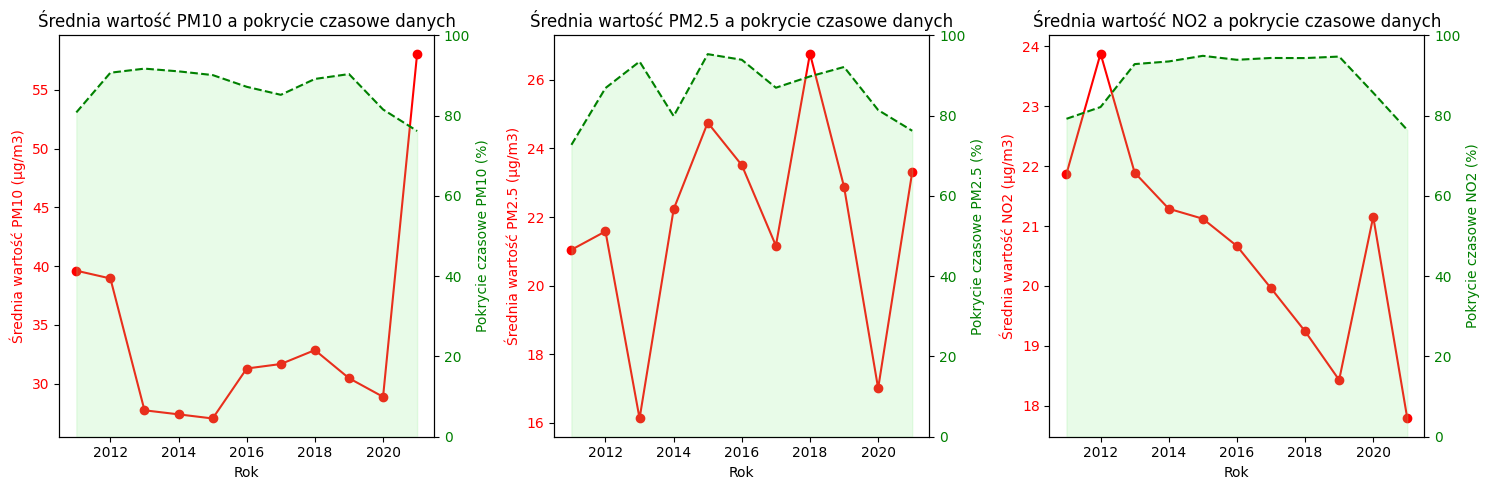

In [9]:
mean_coverage_PM10 = df[df['Measurement Year'] > 2010].groupby('Measurement Year')['PM10 temporal coverage (%)'].mean()
mean_coverage_PM25 = df[df['Measurement Year'] > 2010].groupby('Measurement Year')['PM25 temporal coverage (%)'].mean()
mean_coverage_NO2 = df[df['Measurement Year'] > 2010].groupby('Measurement Year')['NO2 temporal coverage (%)'].mean()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

#PM10
color = 'red'
ax1.plot(df_mean_PM10.index, df_mean_PM10.values, color=color, marker='o')
ax1.set_xlabel('Rok')
ax1.set_ylabel('Średnia wartość PM10 (μg/m3)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1_2 = ax1.twinx()  
color = 'green'
ax1_2.plot(mean_coverage_PM10.index, mean_coverage_PM10.values, color=color, linestyle='--')
ax1_2.fill_between(mean_coverage_PM10.index, 0, mean_coverage_PM10.values, color='lightgreen', alpha=0.2)
ax1_2.set_ylabel('Pokrycie czasowe PM10 (%)', color=color)
ax1_2.tick_params(axis='y', labelcolor=color)
ax1_2.set_ylim(0, 100) 

#PM2.5
color = 'red'
ax2.plot(df_mean_PM2_5.index, df_mean_PM2_5.values, color=color, marker='o')
ax2.set_xlabel('Rok')
ax2.set_ylabel('Średnia wartość PM2.5 (μg/m3)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2_2 = ax2.twinx()  
color = 'green'
ax2_2.plot(mean_coverage_PM25.index, mean_coverage_PM25.values, color=color, linestyle='--')
ax2_2.fill_between(mean_coverage_PM25.index, 0, mean_coverage_PM25.values, color='lightgreen', alpha=0.2)
ax2_2.set_ylabel('Pokrycie czasowe PM2.5 (%)', color=color)
ax2_2.tick_params(axis='y', labelcolor=color)
ax2_2.set_ylim(0, 100) 

#NO2
color = 'red'
ax3.plot(df_mean_NO2.index, df_mean_NO2.values, color=color, marker='o')
ax3.set_xlabel('Rok')
ax3.set_ylabel('Średnia wartość NO2 (μg/m3)', color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax3_2 = ax3.twinx()  
color = 'green'
ax3_2.plot(mean_coverage_NO2.index, mean_coverage_NO2.values, color=color, linestyle='--')
ax3_2.fill_between(mean_coverage_NO2.index, 0, mean_coverage_NO2.values, color='lightgreen', alpha=0.2)
ax3_2.set_ylabel('Pokrycie czasowe NO2 (%)', color=color)
ax3_2.tick_params(axis='y', labelcolor=color)
ax3_2.set_ylim(0, 100) 

ax1.set_title('Średnia wartość PM10 a pokrycie czasowe danych')
ax2.set_title('Średnia wartość PM2.5 a pokrycie czasowe danych')
ax3.set_title('Średnia wartość NO2 a pokrycie czasowe danych')

plt.tight_layout()  
plt.show()

Te wykresy mogłyby być bardzo przydatne, gdyby nie duża liczba wartości brakujących w kolumnach mówiących o pokryciu czasowym. Natomiast dla tych danych są mało miarodajne.

Wykresy zależności między stężeniem pyłów zawieszonych a stężeniem dwutlenku azotu

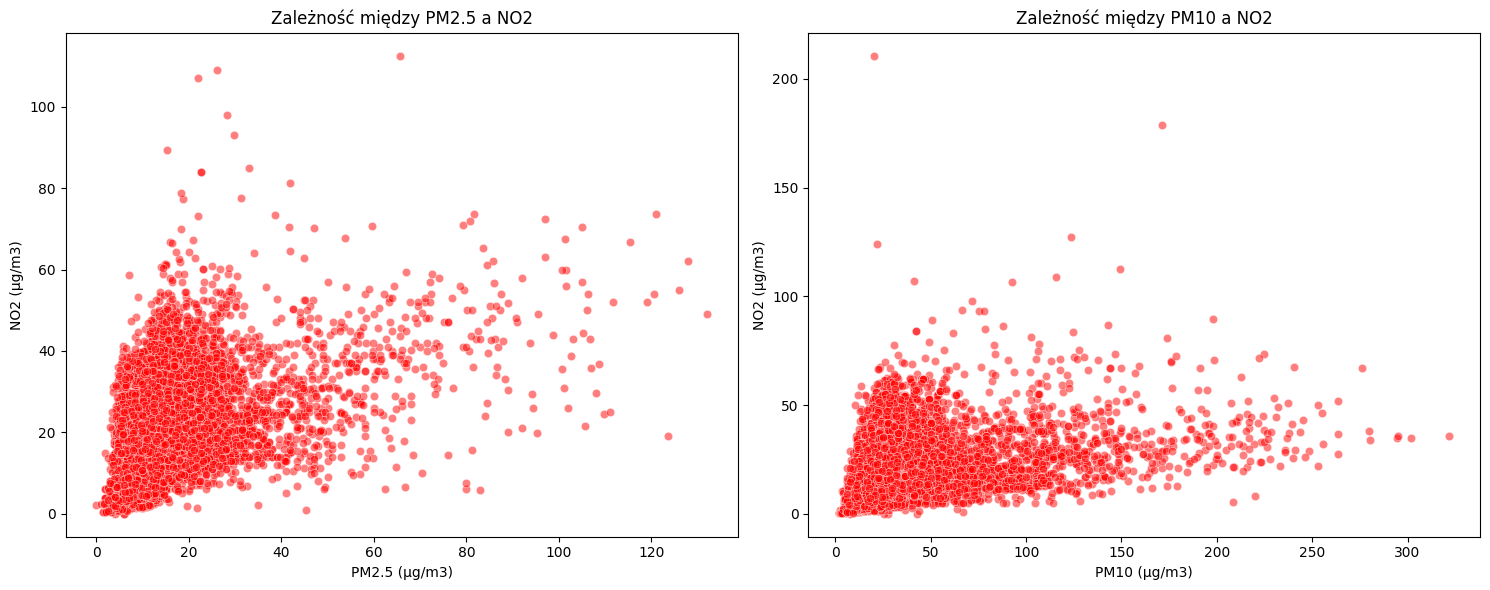

Korelacja między PM2.5 a NO2 wynosi: 0.43016965752149483
Korelacja między PM10 a NO2 wynosi: 0.3055597306579173


In [68]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(data=df, x='PM2.5 (μg/m3)', y='NO2 (μg/m3)', ax=axs[0],alpha=0.5, color='red')
axs[0].set_title('Zależność między PM2.5 a NO2')
axs[0].set_xlabel('PM2.5 (μg/m3)')
axs[0].set_ylabel('NO2 (μg/m3)')

sns.scatterplot(data=df, x='PM10 (μg/m3)', y='NO2 (μg/m3)', ax=axs[1],alpha=0.5, color='red')
axs[1].set_title('Zależność między PM10 a NO2')
axs[1].set_xlabel('PM10 (μg/m3)')
axs[1].set_ylabel('NO2 (μg/m3)')

plt.tight_layout()
plt.show()

correlation = df['PM2.5 (μg/m3)'].corr(df['NO2 (μg/m3)'])
print("Korelacja między PM2.5 a NO2 wynosi:", correlation)
correlation = df['PM10 (μg/m3)'].corr(df['NO2 (μg/m3)'])
print("Korelacja między PM10 a NO2 wynosi:", correlation)

Korelacja między zanieczyszczeniami jest zauważalna, ale nie jest wysoka.

Poniżej został umieszczony skrypt użyty do pozyskania danych lokalizacyjnych miast.

In [ ]:
'''
import numpy as np
from geopy.geocoders import Nominatim
import pandas as pd 

df = pd.read_excel('dane_who.xlsx', sheet_name='AAP_2022_city_v9', header=0)
df.head()

df_do_pobrania = df[["WHO Country Name", "City or Locality"]]
df_do_pobrania.head()
unique_country_cities = df_do_pobrania.drop_duplicates().reset_index(drop=True)
unique_country_cities.describe()
lat = []
long = []
loc = Nominatim(user_agent="Geopy Library")
for index, row in unique_country_cities.iterrows():
    
    try:
        getLoc = loc.geocode(f"{row['City or Locality']}, {row['WHO Country Name']}")
    except: 
        print(f"Problem with connection, try to rerun operation for {index} index")
        lat.append(np.nan)
        long.append(np.nan)
        continue
    try:
        lat.append(getLoc.latitude)
        long.append(getLoc.longitude)
    except:
        try:
            getLoc = loc.geocode(f"{row['WHO Country Name']}, {row['City or Locality']}")
        except: 
            print(f"Problem with connection, try to rerun operation for {index} index")
            lat.append(np.nan)
            long.append(np.nan)
            continue
        try:
            lat.append(getLoc.latitude)
            long.append(getLoc.longitude)
        except:
            try:
                getLoc = loc.geocode(f"{row['City or Locality']}")
            except: 
                print(f"Problem with connection, try to rerun operation for {index} index")
                lat.append(np.nan)
                long.append(np.nan)
                continue
            try:
                lat.append(getLoc.latitude)
                long.append(getLoc.longitude)
            except:
                lat.append(np.nan)
                long.append(np.nan)
            print(f"Missing data for {index} index")
unique_country_cities["lat"] = lat
unique_country_cities["long"] = long
'''

In [123]:
df_coords = pd.read_csv('pobrane_kordy')

In [124]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"), engine="pyogrio")

C:\Users\gosia\AppData\Local\Temp\ipykernel_24508\547189185.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"), engine="pyogrio")


Wizualizacje rozkładu zanieczyszczeń PM10 na mapie świata w poszczególnych latach

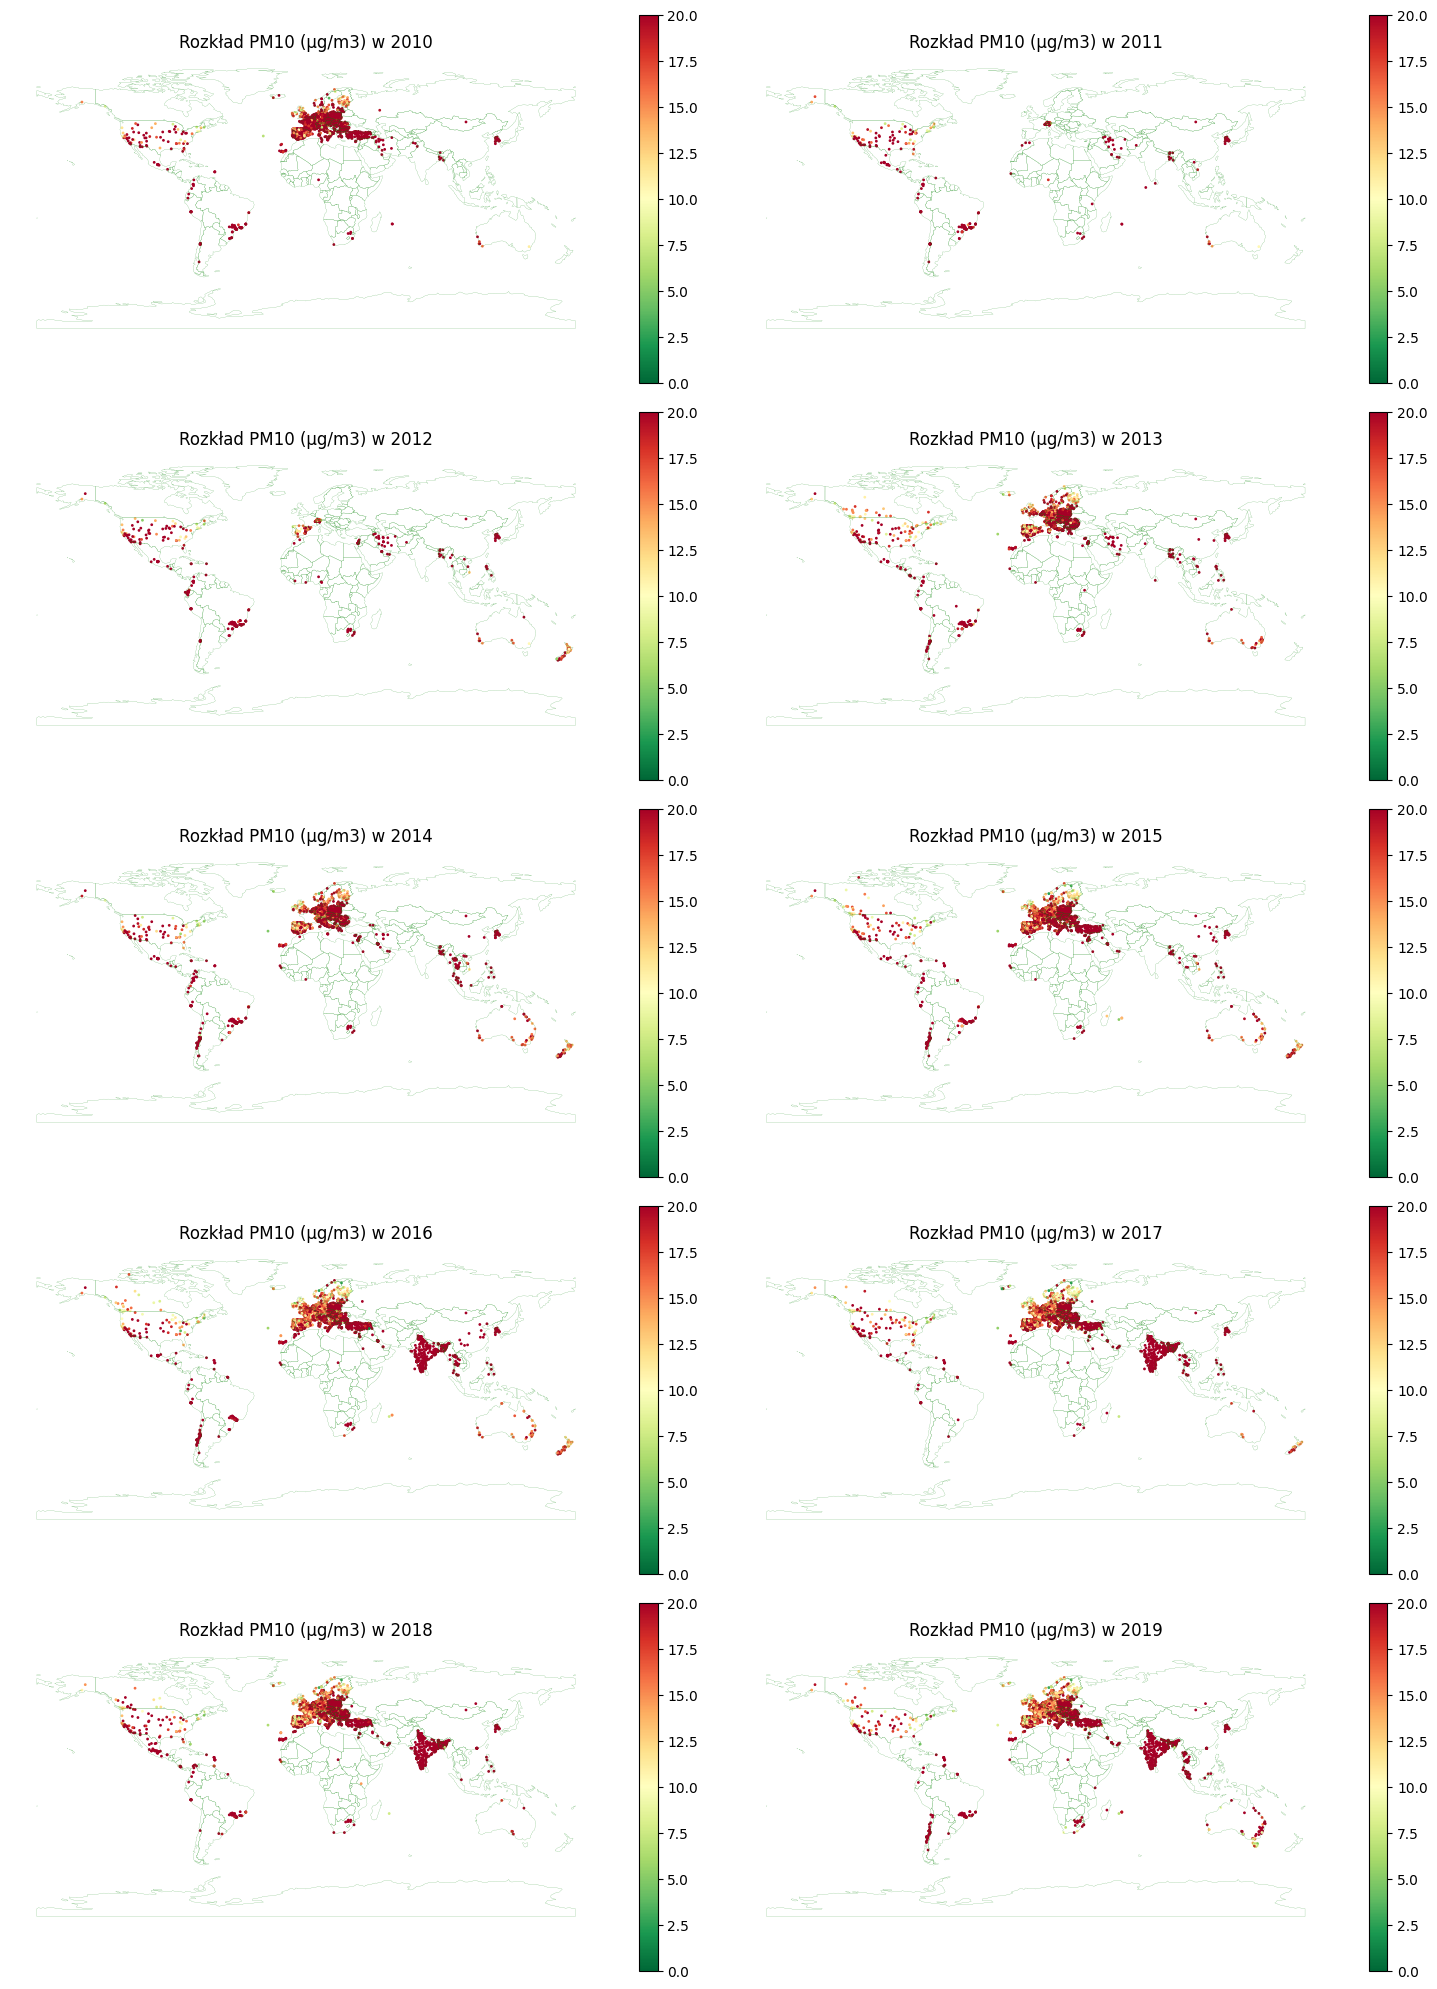

In [72]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for i in range(2010, 2020):

    dfi = df_coords.loc[df_coords['Measurement Year'] == i]
    geometry = gpd.points_from_xy(dfi['long'], dfi['lat'])
    gdf = gpd.GeoDataFrame(dfi, geometry=geometry)
    
    ax = axes[i-2010]
    gdf.plot(ax=ax, column='PM10 (μg/m3)', cmap="RdYlGn_r", legend=True, markersize=1, vmin=0, vmax=20)
    world.boundary.plot(ax=ax, linewidth=0.1, color="green")
  
    ax.set_title(f'Rozkład PM10 (μg/m3) w {i}')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

Skala została ustawiona 0-20, ponieważ norma WHO średniego rocznego stężenia pyłu PM10 wynosi 20 µg/m, zatem wszystkie punkty gdzie została przekroczona są pokazane kolorem ciemnoczerwonym.

Wizualizacje rozkładu zanieczyszczeń PM2.5 na mapie świata w poszczególnych latach

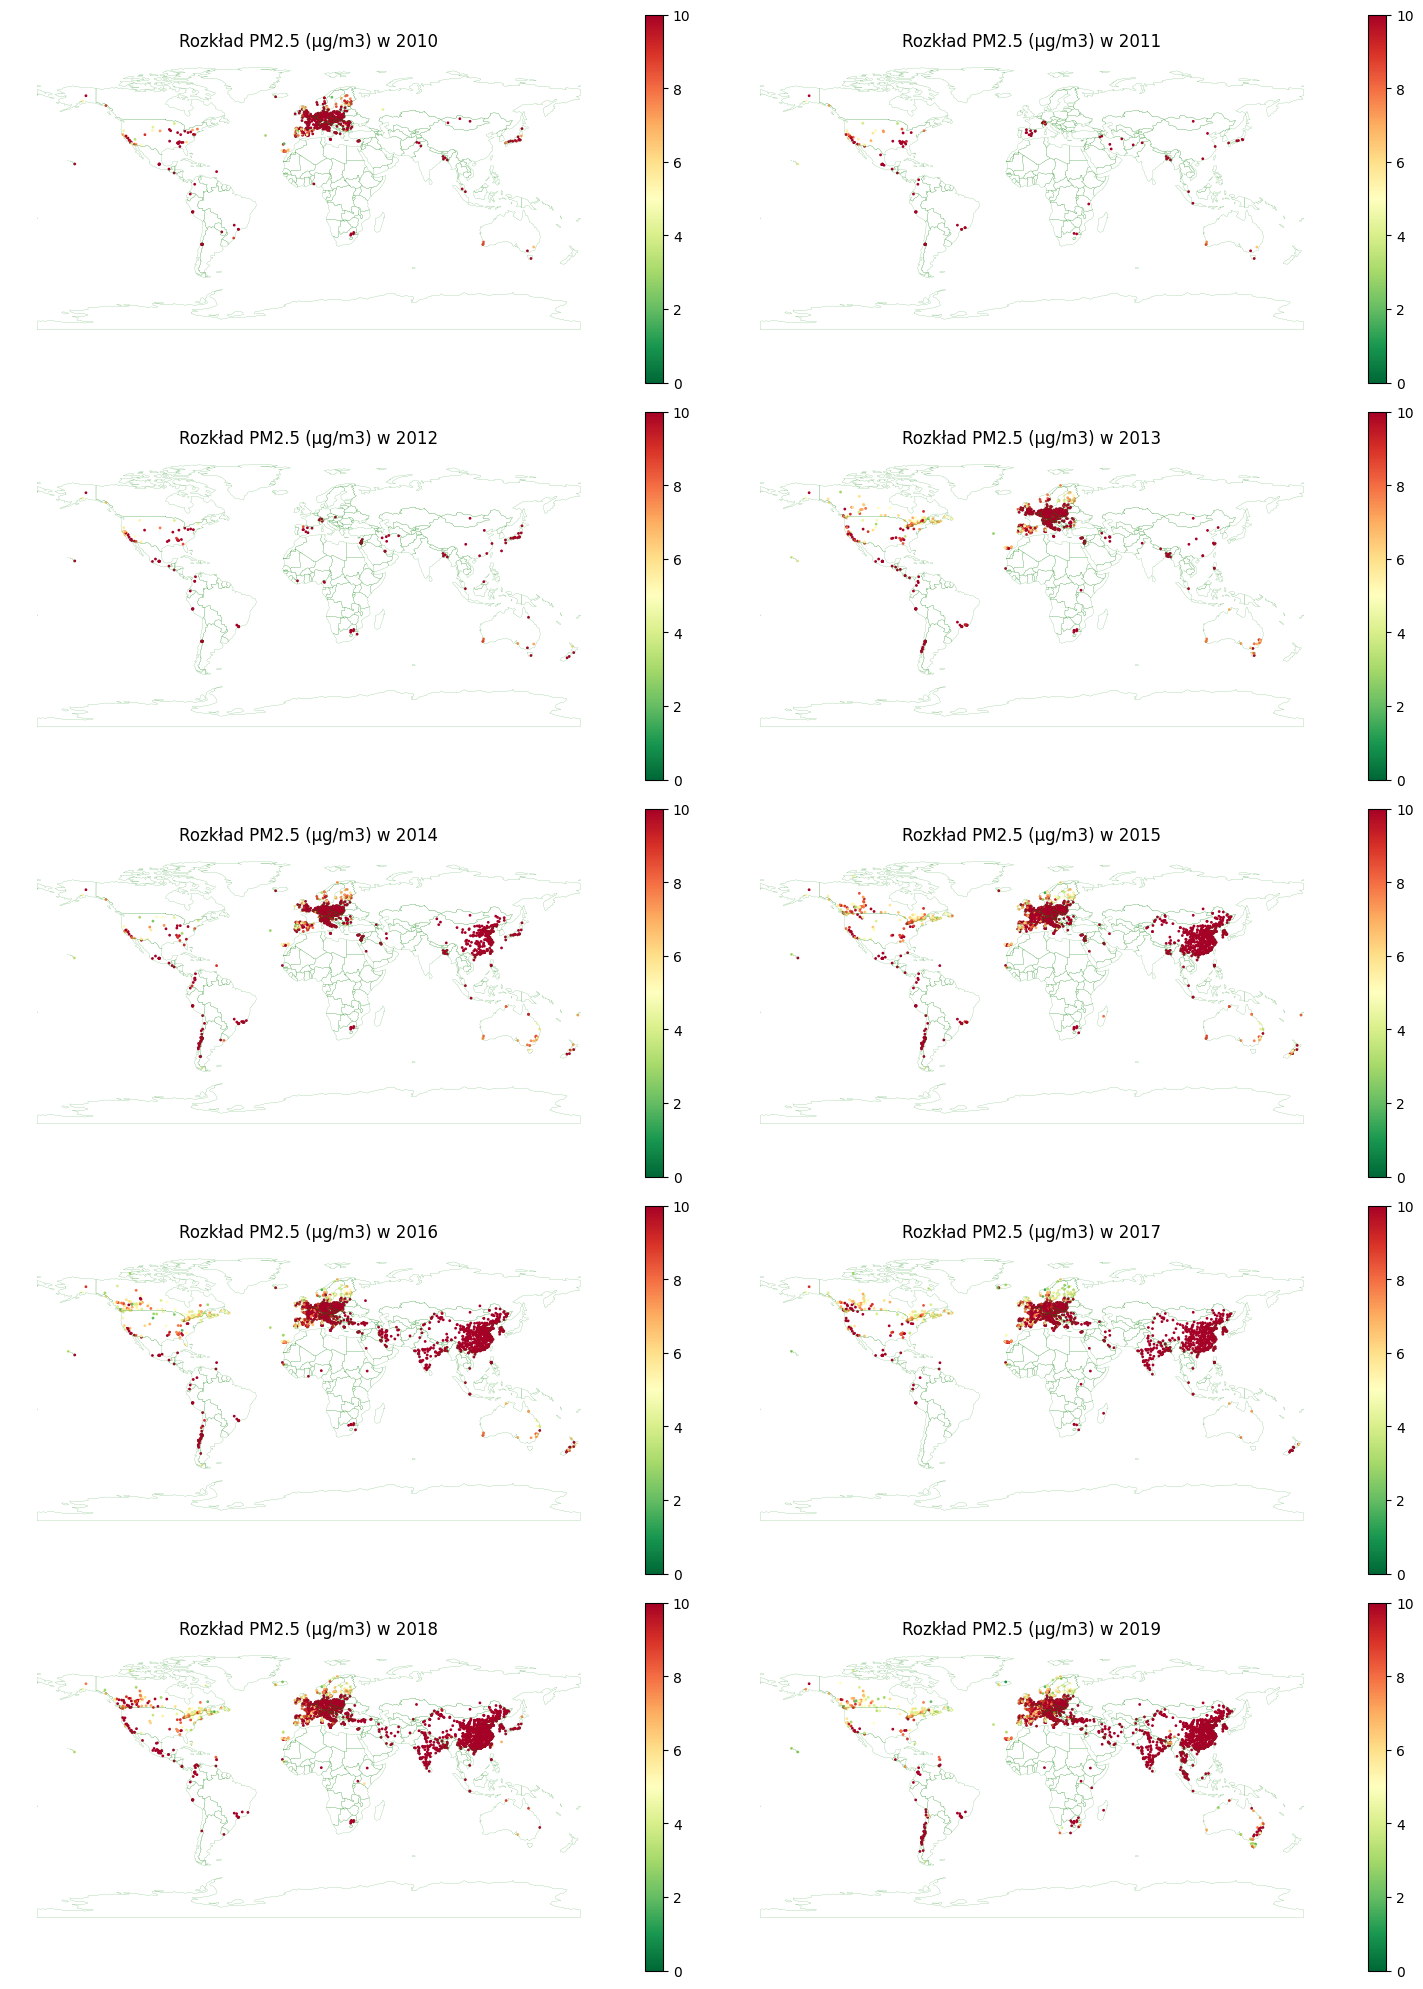

In [74]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for i in range(2010, 2020):

    dfi = df_coords.loc[df_coords['Measurement Year'] == i]
    geometry = gpd.points_from_xy(dfi['long'], dfi['lat'])
    gdf = gpd.GeoDataFrame(dfi, geometry=geometry)
    
    ax = axes[i-2010]
    gdf.plot(ax=ax, column='PM2.5 (μg/m3)', cmap="RdYlGn_r", legend=True, markersize=1, vmin=0, vmax=10)
    world.boundary.plot(ax=ax, linewidth=0.1, color="green")
  
    ax.set_title(f'Rozkład PM2.5 (μg/m3) w {i}')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

W przypadku PM2.5 norma według WHO wynosi 10 µg/m.

Wizualizacje rozkładu zanieczyszczeń NO2 na mapie świata w poszczególnych latach

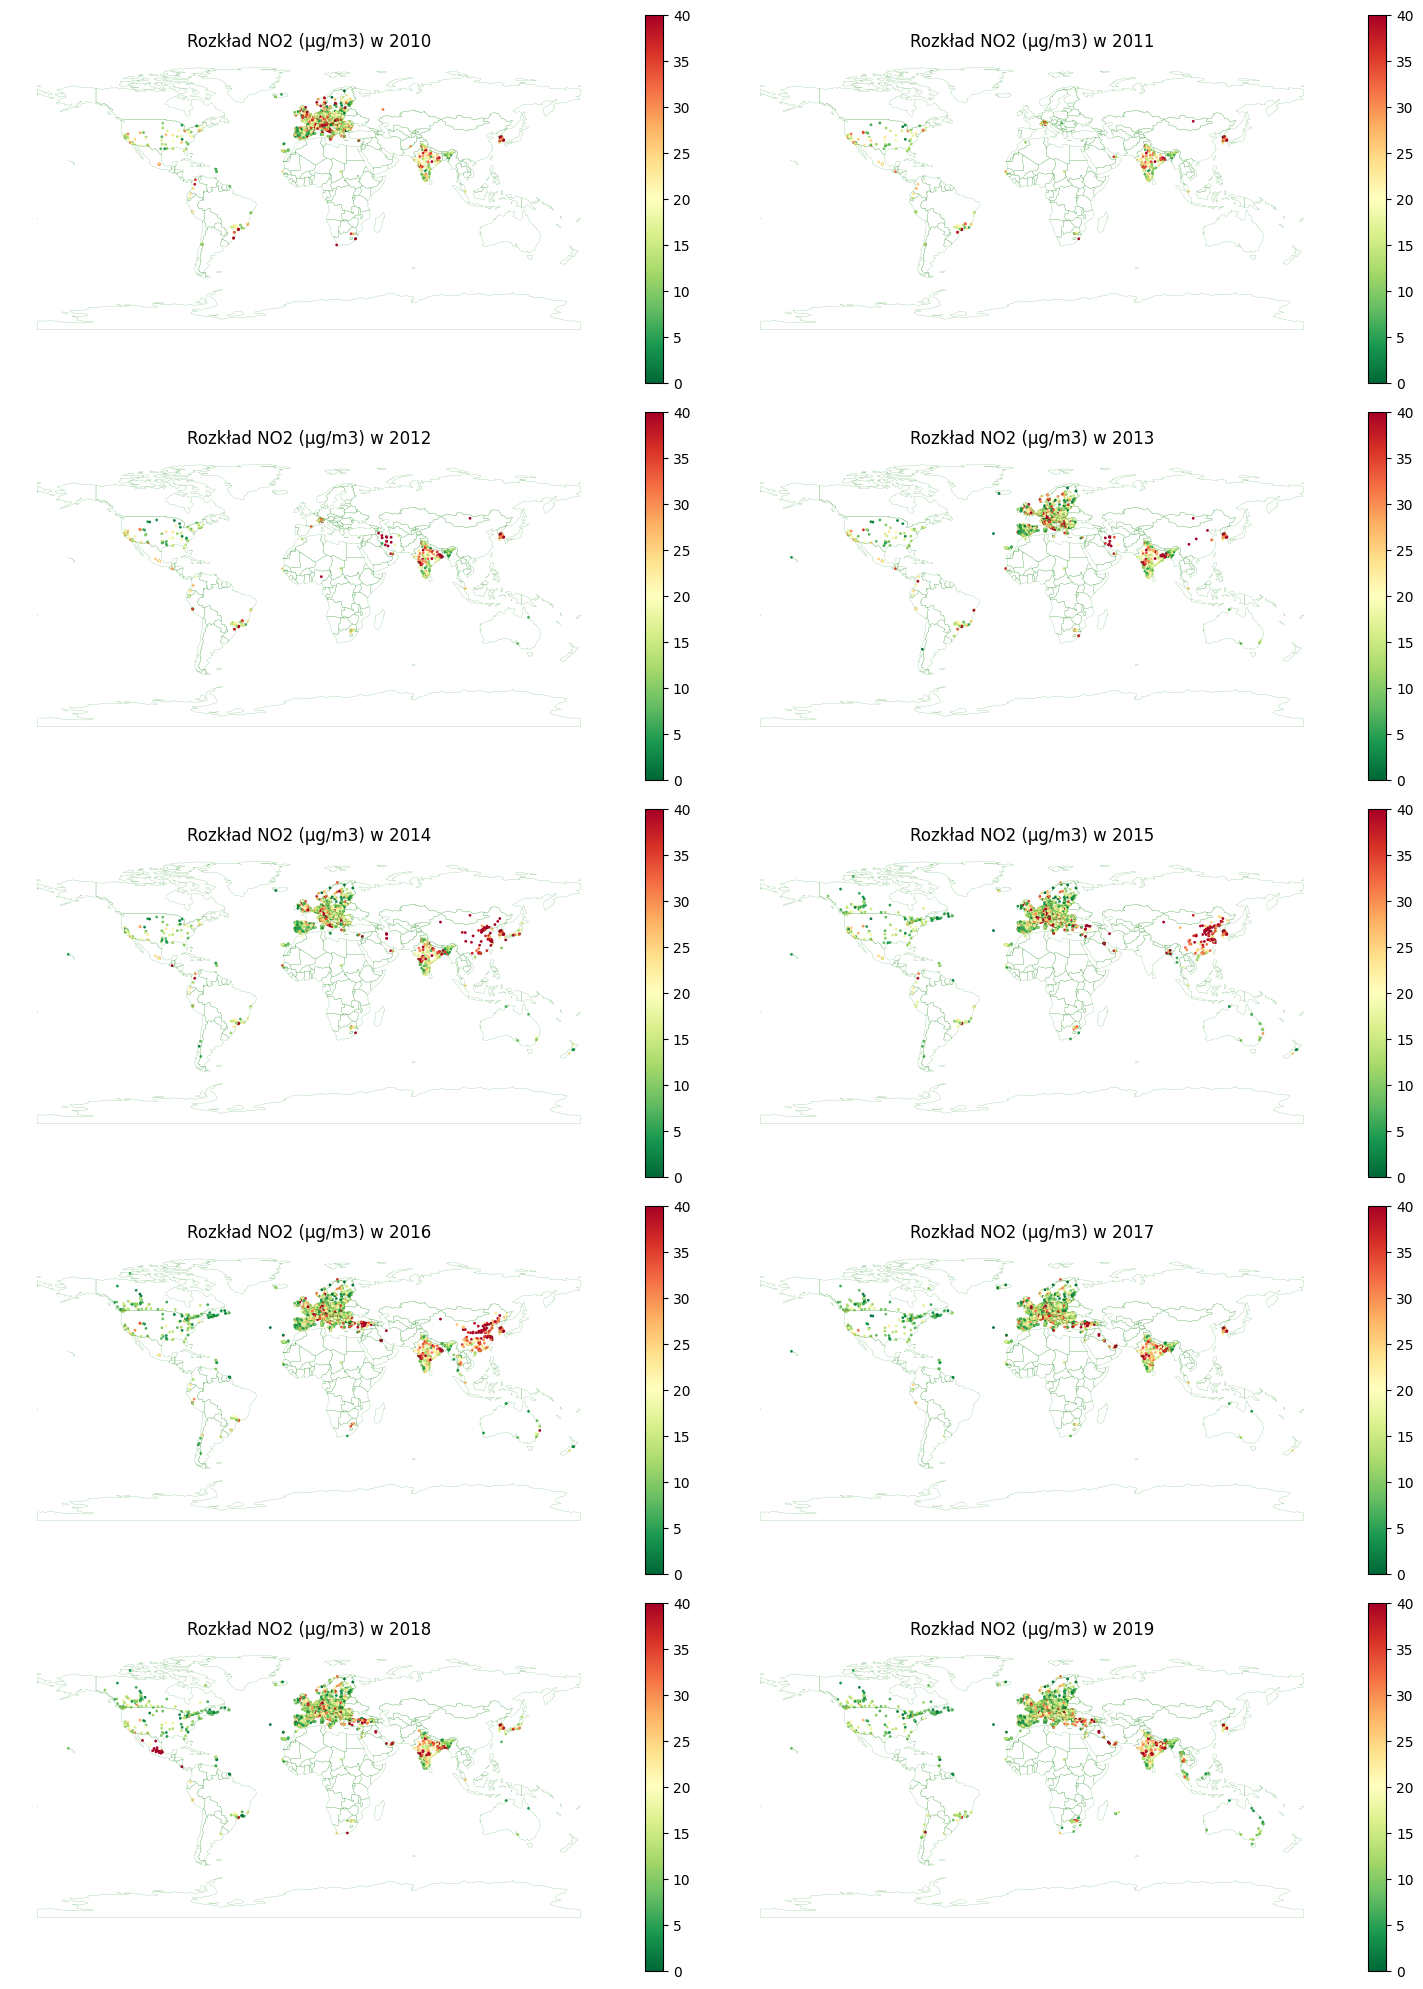

In [76]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for i in range(2010, 2020):

    dfi = df_coords.loc[df_coords['Measurement Year'] == i]
    geometry = gpd.points_from_xy(dfi['long'], dfi['lat'])
    gdf = gpd.GeoDataFrame(dfi, geometry=geometry)
    
    ax = axes[i-2010]
    gdf.plot(ax=ax, column='NO2 (μg/m3)', cmap="RdYlGn_r", legend=True, markersize=1, vmin=0, vmax=40)
    world.boundary.plot(ax=ax, linewidth=0.1, color="green")
  
    ax.set_title(f'Rozkład NO2 (μg/m3) w {i}')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

GIOS podaje normy roczne NO2 40 µg/m3, zatem taka skala została ustawiona do tych wykresów.

In [125]:
avg_pm10_by_city = df_coords.groupby('City or Locality')['PM10 (μg/m3)'].mean()
avg_pm25_by_city = df_coords.groupby('City or Locality')['PM2.5 (μg/m3)'].mean()
avg_no2_by_city = df_coords.groupby('City or Locality')['NO2 (μg/m3)'].mean()

avg_pm10_df = pd.DataFrame(avg_pm10_by_city).reset_index()
avg_pm25_df = pd.DataFrame(avg_pm25_by_city).reset_index()
avg_no2_df = pd.DataFrame(avg_no2_by_city).reset_index()

df_coords = pd.merge(df_coords, avg_pm10_df, on='City or Locality', suffixes=('', '_avg'))
df_coords = pd.merge(df_coords, avg_pm25_df, on='City or Locality', suffixes=('', '_avg'))
df_coords = pd.merge(df_coords, avg_no2_df, on='City or Locality', suffixes=('', '_avg'))

df_coords.rename(columns={'PM10 (μg/m3)_avg': 'Avg_PM10', 'PM2.5 (μg/m3)_avg': 'Avg_PM2.5', 'NO2 (μg/m3)_avg': 'Avg_NO2'}, inplace=True)

display(df_coords)

WHO Region ISO3 WHO Country Name City or Locality  \
0      Eastern Mediterranean Region  AFG      Afghanistan            Kabul   
1                   European Region  ALB          Albania           Durres   
2                   European Region  ALB          Albania           Durres   
3                   European Region  ALB          Albania          Elbasan   
4                   European Region  ALB          Albania          Elbasan   
...                             ...  ...              ...              ...   
32186                African Region  ZAF     South Africa       West Coast   
32187                African Region  ZAF     South Africa       West Coast   
32188                African Region  ZAF     South Africa       West Coast   
32189                African Region  ZAF     South Africa       West Coast   
32190                African Region  ZAF     South Africa        West Rand   

       Measurement Year  PM2.5 (μg/m3)  PM10 (μg/m3)  NO2 (μg/m3)  \
0                  2019         119.77           NaN          NaN   
1                  2015            NaN         17.65        26.63   
2                  2016          14.32         24.56        24.78   
3                  2015            NaN           NaN        23.96   
4                  2016            NaN           NaN        26.26   
...                 ...            ...           ...          ...   
32186              2015           7.47         24.64         7.64   
32187              2016           8.42         33.28         7.27   
32188              2017           6.83         20.49         8.72   
32189              2018           6.10         17.99         7.15   
32190              2016            NaN           NaN        17.85   

       PM25 temporal coverage (%)  PM10 temporal coverage (%)  \
0                            18.0                         NaN   
1                             NaN                         NaN   
2                             NaN                         NaN   
3                             NaN                         NaN   
4                             NaN                         NaN   
...                           ...                         ...   
32186                        75.0                        75.0   
32187                        75.0                        75.0   
32188                        75.0                        75.0   
32189                        75.0                        75.0   
32190                         NaN                         NaN   

       NO2 temporal coverage (%)  \
0                            NaN   
1                      83.961187   
2                      87.932605   
3                      97.853881   
4                      96.049636   
...                          ...   
32186                  75.000000   
32187                  75.000000   
32188                  75.000000   
32189                  75.000000   
32190                  75.000000   

                                               Reference  \
0      U.S. Department of State, United States Enviro...   
1       European Environment Agency (downloaded in 2021)   
2       European Environment Agency (downloaded in 2021)   
3       European Environment Agency (downloaded in 2021)   
4       European Environment Agency (downloaded in 2021)   
...                                                  ...   
32186       South African Air Quality Information System   
32187       South African Air Quality Information System   
32188       South African Air Quality Information System   
32189       South African Air Quality Information System   
32190       South African Air Quality Information System   

      Number and type of monitoring stations  Version of the database  Status  \
0                                        NaN                     2022     NaN   
1                                        NaN                     2022     NaN   
2                                        NaN                     2022     NaN   


Tworzenie nowych ramek danech ze współrzędnymi regionów

In [126]:
regions = df['WHO Region'].unique()
coord_dataframes = []
for region in regions:
    name_df = f"coord_df_{region.replace(' ', '')}"
    exec(f"{name_df} = df_coords[df_coords['WHO Region'] == '{region}']")
    coord_dataframes.append(name_df)

Przedstawienie średniego rozkładu zanieczyszczenia PM10, PM2.5 i NO2 na mapie Europy, tym razem skala ustawiona jest tak, aby jak najlepiej pokazać zróżnicowanie wartości, a nie według norm (na wcześniejszych wykresach dobitnie widać że są przekroczone).

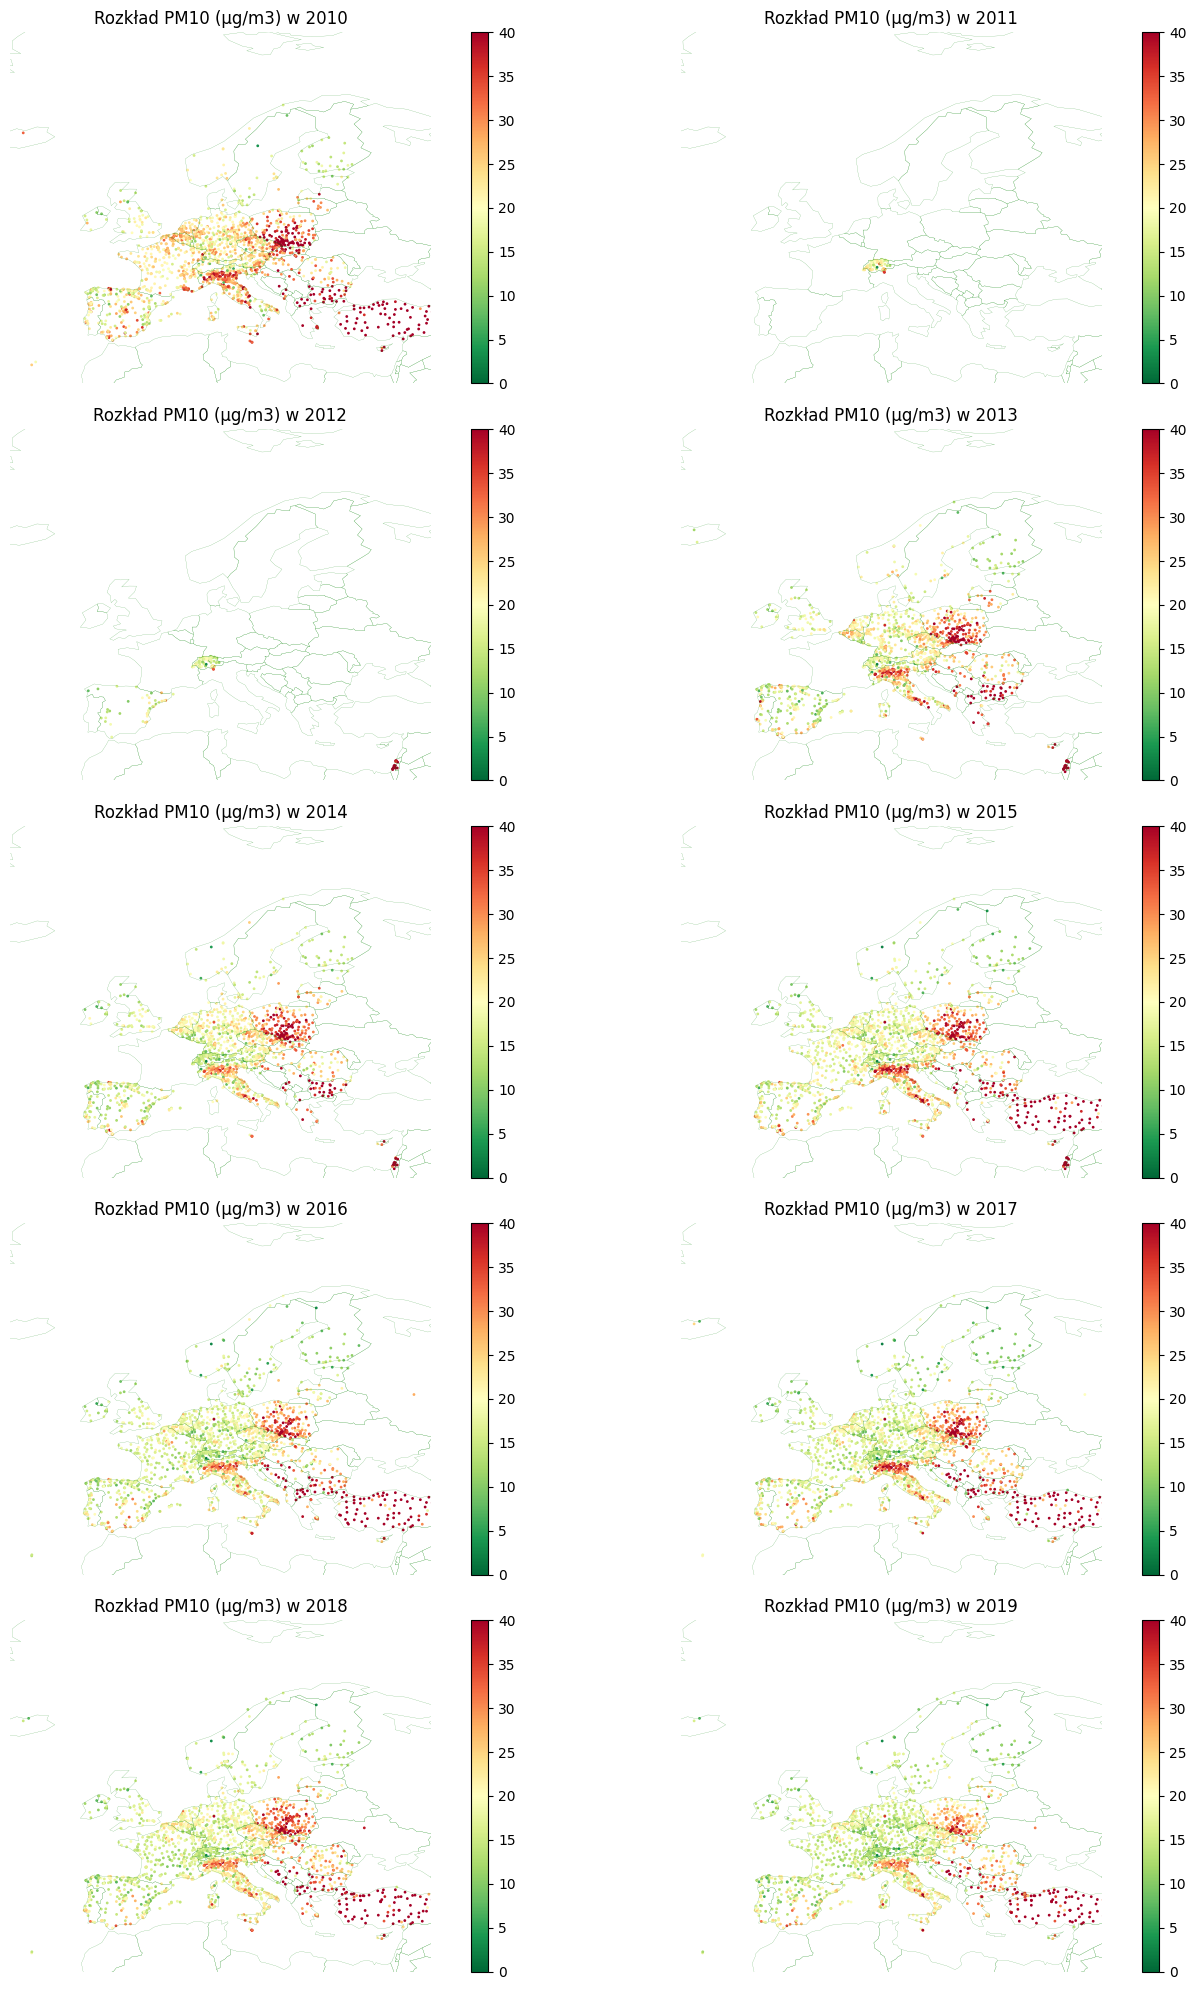

In [91]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for i in range(2010, 2020):

    dfi = coord_df_EuropeanRegion.loc[coord_df_EuropeanRegion['Measurement Year'] == i]
    geometry = gpd.points_from_xy(dfi['long'], dfi['lat'])
    gdf = gpd.GeoDataFrame(dfi, geometry=geometry)
    
    ax = axes[i-2010]
    gdf.plot(ax=ax, column='PM10 (μg/m3)', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
    world.boundary.plot(ax=ax, linewidth=0.1, color="green")
  
    ax.set_title(f'Rozkład PM10 (μg/m3) w {i}')
    ax.set_xlim([-20, 40])
    ax.set_ylim([30, 80])
    ax.set_axis_off()

plt.tight_layout()
plt.show()

Niestety Polska prezentuje się dość niechlubnie.

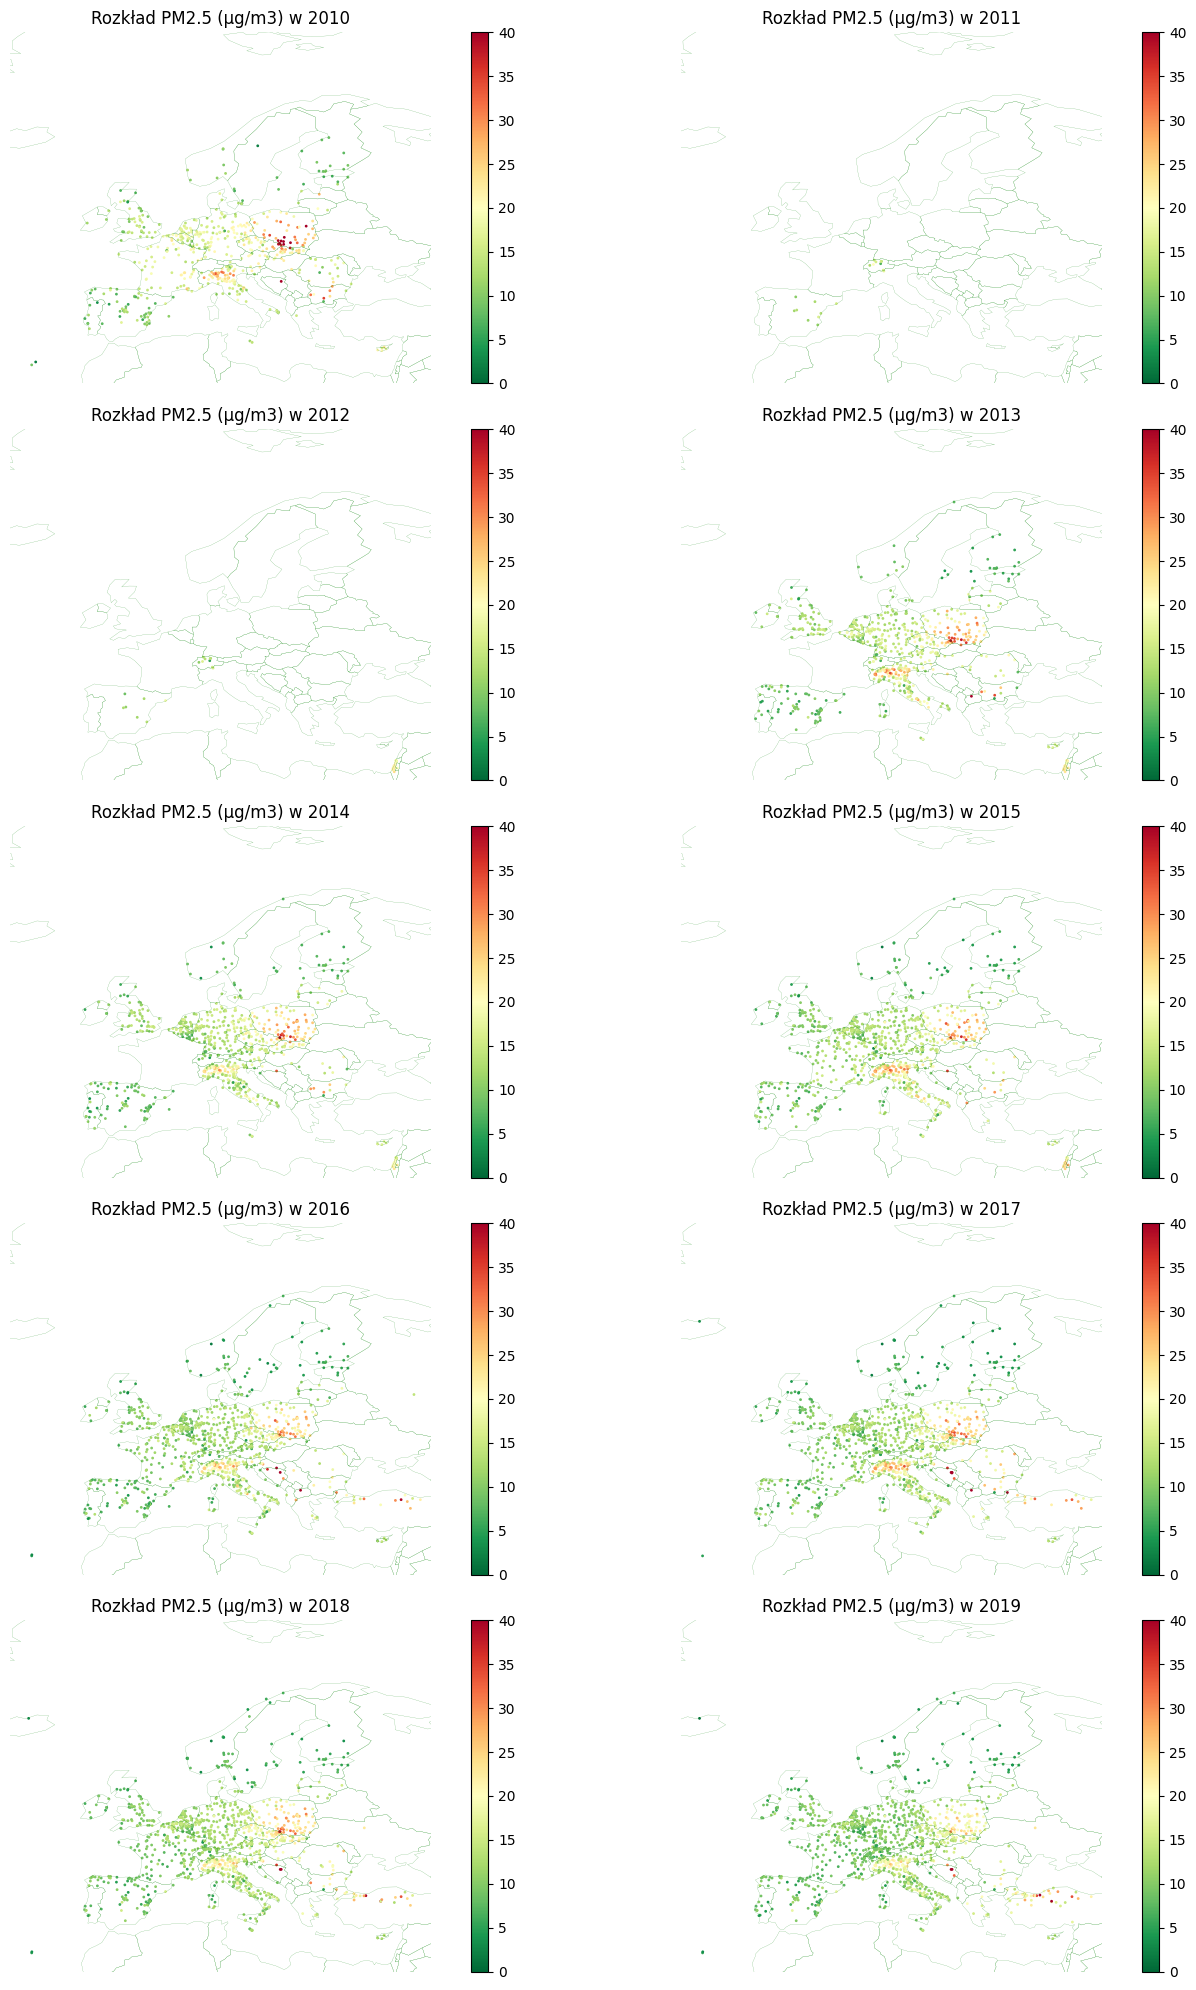

In [92]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for i in range(2010, 2020):

    dfi = coord_df_EuropeanRegion.loc[coord_df_EuropeanRegion['Measurement Year'] == i]
    geometry = gpd.points_from_xy(dfi['long'], dfi['lat'])
    gdf = gpd.GeoDataFrame(dfi, geometry=geometry)
    
    ax = axes[i-2010]
    gdf.plot(ax=ax, column='PM2.5 (μg/m3)', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
    world.boundary.plot(ax=ax, linewidth=0.1, color="green")
  
    ax.set_title(f'Rozkład PM2.5 (μg/m3) w {i}')
    ax.set_xlim([-20, 40])
    ax.set_ylim([30, 80])
    ax.set_axis_off()

plt.tight_layout()
plt.show()

Dla NO2 akurat pokrywa się z normą (40 μg/m3).

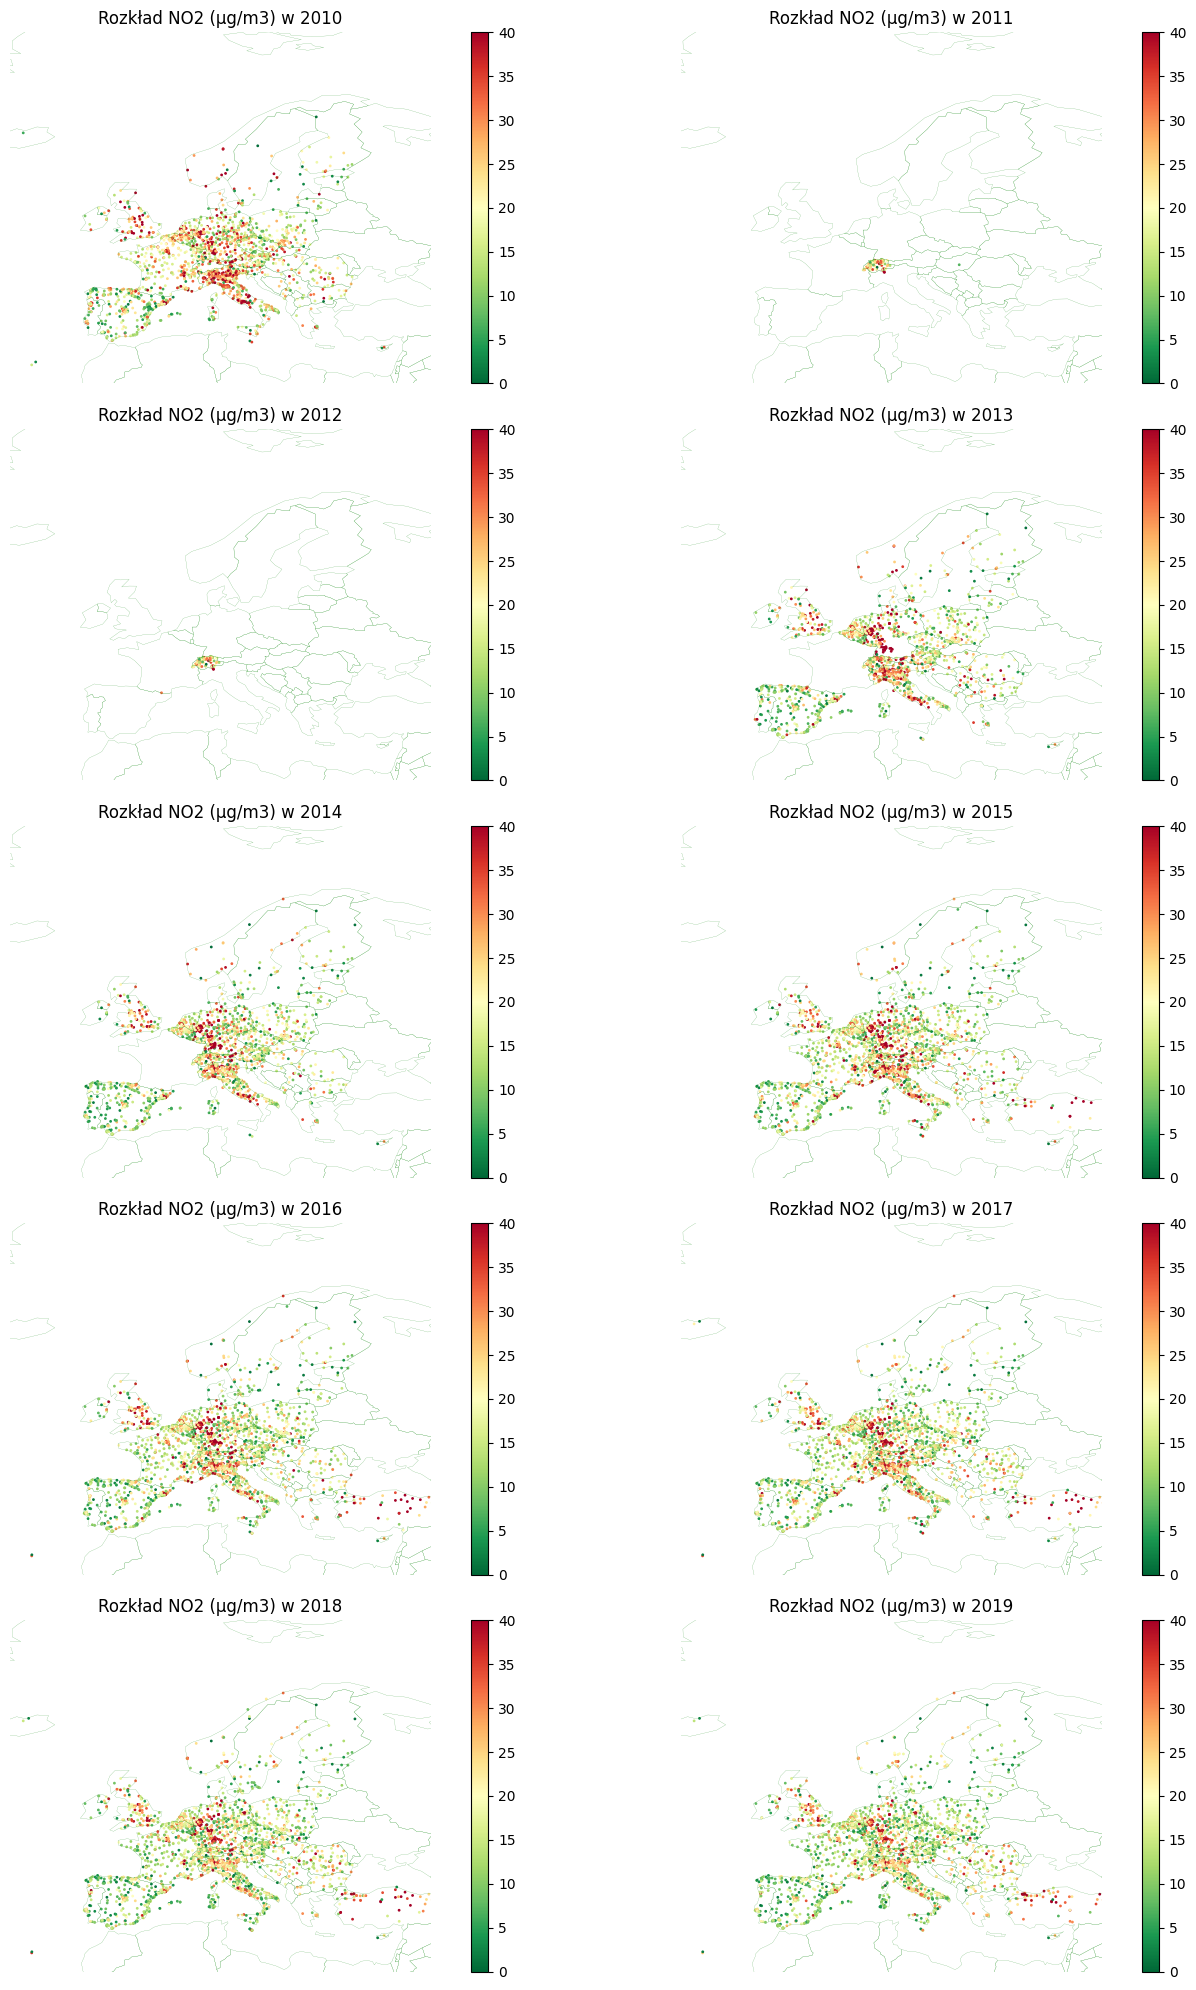

In [93]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for i in range(2010, 2020):

    dfi = coord_df_EuropeanRegion.loc[coord_df_EuropeanRegion['Measurement Year'] == i]
    geometry = gpd.points_from_xy(dfi['long'], dfi['lat'])
    gdf = gpd.GeoDataFrame(dfi, geometry=geometry)
    
    ax = axes[i-2010]
    gdf.plot(ax=ax, column='NO2 (μg/m3)', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
    world.boundary.plot(ax=ax, linewidth=0.1, color="green")
  
    ax.set_title(f'Rozkład NO2 (μg/m3) w {i}')
    ax.set_xlim([-20, 40])
    ax.set_ylim([30, 80])
    ax.set_axis_off()

plt.tight_layout()
plt.show()

Wizualizacje średnich wartości zanieczyszczeń ze wszystkich lat dla każdego regionu

Europa

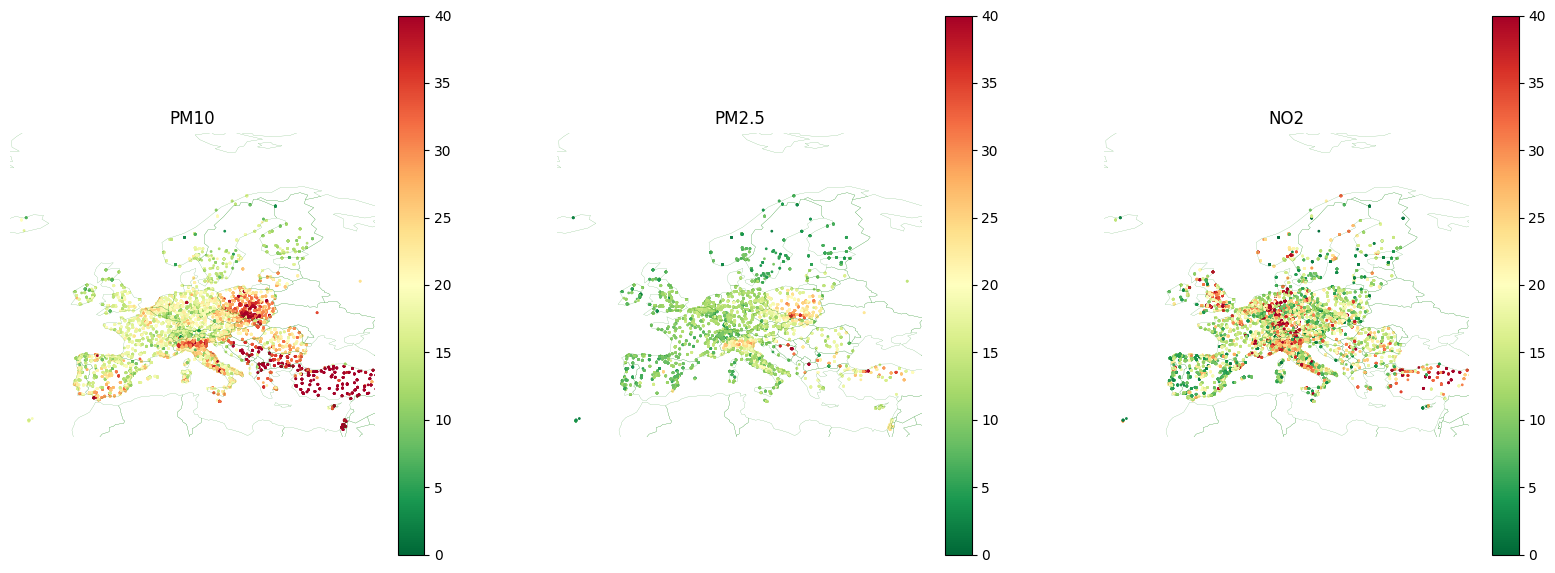

In [131]:
geometry = gpd.points_from_xy(coord_df_EuropeanRegion['long'], coord_df_EuropeanRegion['lat'])

gdf = gpd.GeoDataFrame(coord_df_EuropeanRegion, geometry=geometry)

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

gdf.plot(ax=axes[0], column='Avg_PM10', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[0], linewidth=0.1, color="green")
axes[0].set_title('PM10')
axes[0].set_axis_off()
axes[0].set_xlim([-20, 40])
axes[0].set_ylim([30, 80])

gdf.plot(ax=axes[1], column='Avg_PM2.5', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[1], linewidth=0.1, color="green")
axes[1].set_title('PM2.5')
axes[1].set_axis_off()
axes[1].set_xlim([-20, 40])
axes[1].set_ylim([30, 80])

gdf.plot(ax=axes[2], column='Avg_NO2', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[2], linewidth=0.1, color="green")
axes[2].set_title('NO2')
axes[2].set_axis_off()
axes[2].set_xlim([-20, 40])
axes[2].set_ylim([30, 80])

plt.show()

Ameryki

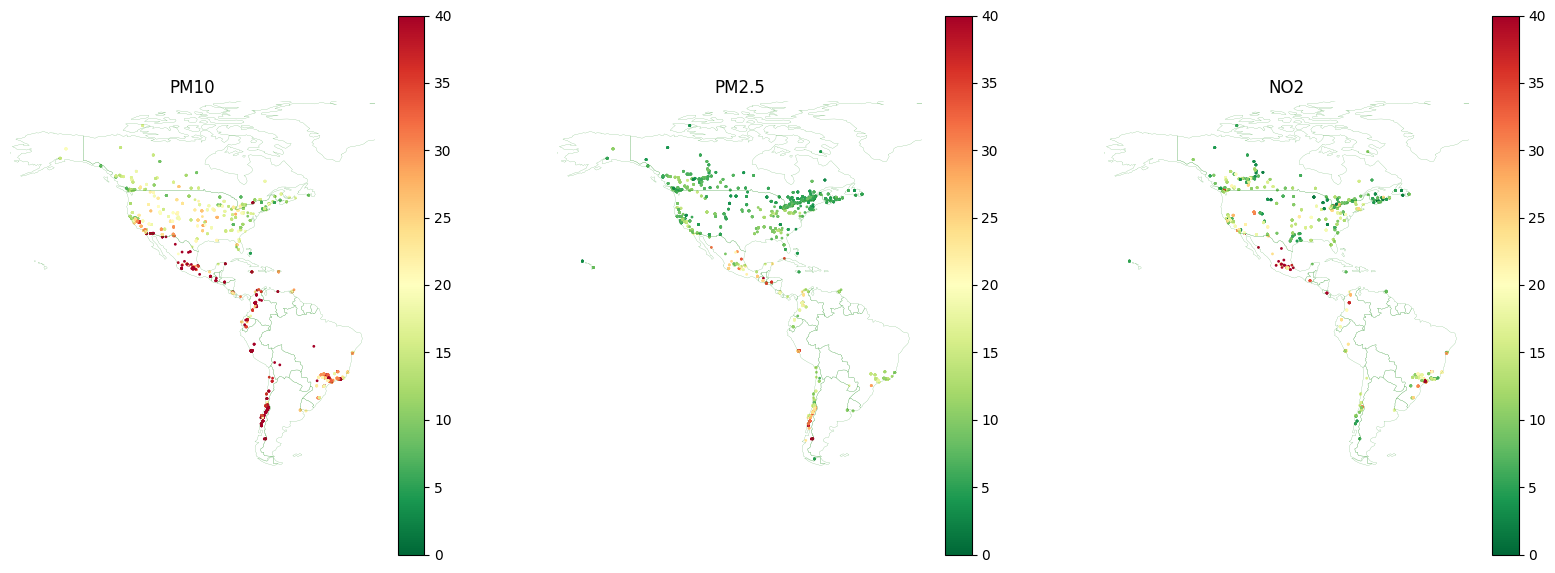

In [133]:
geometry = gpd.points_from_xy(coord_df_RegionoftheAmericas['long'], coord_df_RegionoftheAmericas['lat'])

gdf = gpd.GeoDataFrame(coord_df_RegionoftheAmericas, geometry=geometry)

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

gdf.plot(ax=axes[0], column='Avg_PM10', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[0], linewidth=0.1, color="green")
axes[0].set_title('PM10')
axes[0].set_axis_off()
axes[0].set_xlim([-169, -30])
axes[0].set_ylim([-57, 83])


gdf.plot(ax=axes[1], column='Avg_PM2.5', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[1], linewidth=0.1, color="green")
axes[1].set_title('PM2.5')
axes[1].set_axis_off()
axes[1].set_xlim([-169, -30])
axes[1].set_ylim([-57, 83])

gdf.plot(ax=axes[2], column='Avg_NO2', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[2], linewidth=0.1, color="green")
axes[2].set_title('NO2')
axes[2].set_axis_off()
axes[2].set_xlim([-169, -30])
axes[2].set_ylim([-57, 83])


plt.show()

Region Zachodniego Pacyfiku

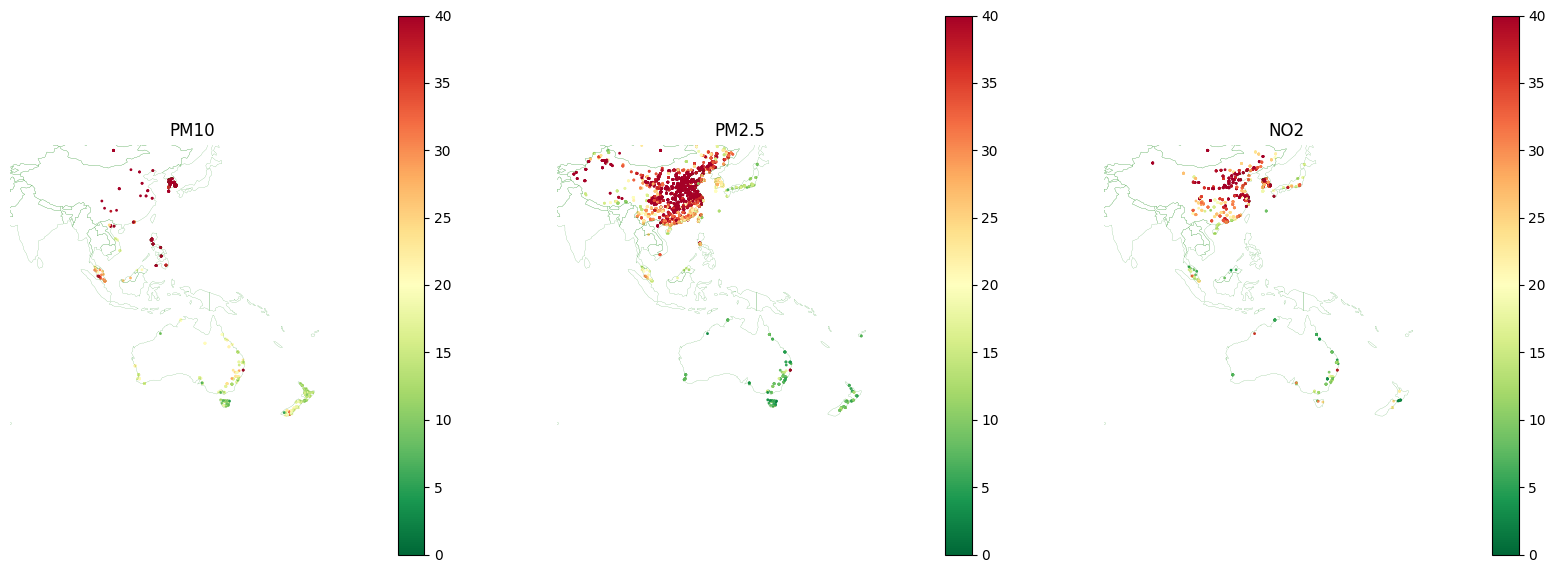

In [141]:
geometry = gpd.points_from_xy(coord_df_WesternPacificRegion['long'], coord_df_WesternPacificRegion['lat'])

gdf = gpd.GeoDataFrame(coord_df_WesternPacificRegion, geometry=geometry)

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

gdf.plot(ax=axes[0], column='Avg_PM10', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[0], linewidth=0.1, color="green")
axes[0].set_title('PM10')
axes[0].set_axis_off()
axes[0].set_xlim([70, 200])
axes[0].set_ylim([-50, 50])


gdf.plot(ax=axes[1], column='Avg_PM2.5', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[1], linewidth=0.1, color="green")
axes[1].set_title('PM2.5')
axes[1].set_axis_off()
axes[1].set_xlim([70, 200])
axes[1].set_ylim([-50, 50])

gdf.plot(ax=axes[2], column='Avg_NO2', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[2], linewidth=0.1, color="green")
axes[2].set_title('NO2')
axes[2].set_axis_off()
axes[2].set_xlim([70, 200])
axes[2].set_ylim([-50, 50])

plt.show()

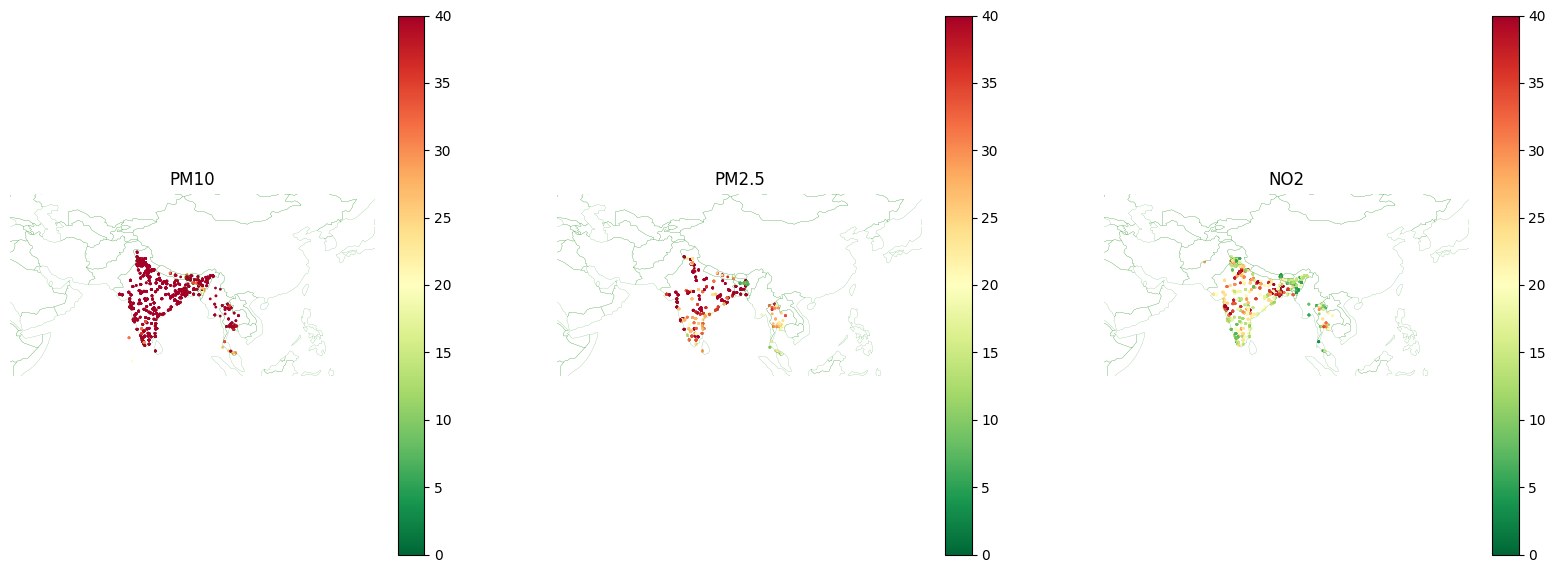

In [150]:
geometry = gpd.points_from_xy(coord_df_SouthEastAsiaRegion['long'], coord_df_SouthEastAsiaRegion['lat'])

gdf = gpd.GeoDataFrame(coord_df_SouthEastAsiaRegion, geometry=geometry)

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

gdf.plot(ax=axes[0], column='Avg_PM10', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[0], linewidth=0.1, color="green")
axes[0].set_title('PM10')
axes[0].set_axis_off()
axes[0].set_xlim([40, 140])
axes[0].set_ylim([0, 50])


gdf.plot(ax=axes[1], column='Avg_PM2.5', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[1], linewidth=0.1, color="green")
axes[1].set_title('PM2.5')
axes[1].set_axis_off()
axes[1].set_xlim([40, 140])
axes[1].set_ylim([0, 50])

gdf.plot(ax=axes[2], column='Avg_NO2', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[2], linewidth=0.1, color="green")
axes[2].set_title('NO2')
axes[2].set_axis_off()
axes[2].set_xlim([40, 140])
axes[2].set_ylim([0, 50])

plt.show()

Afryka

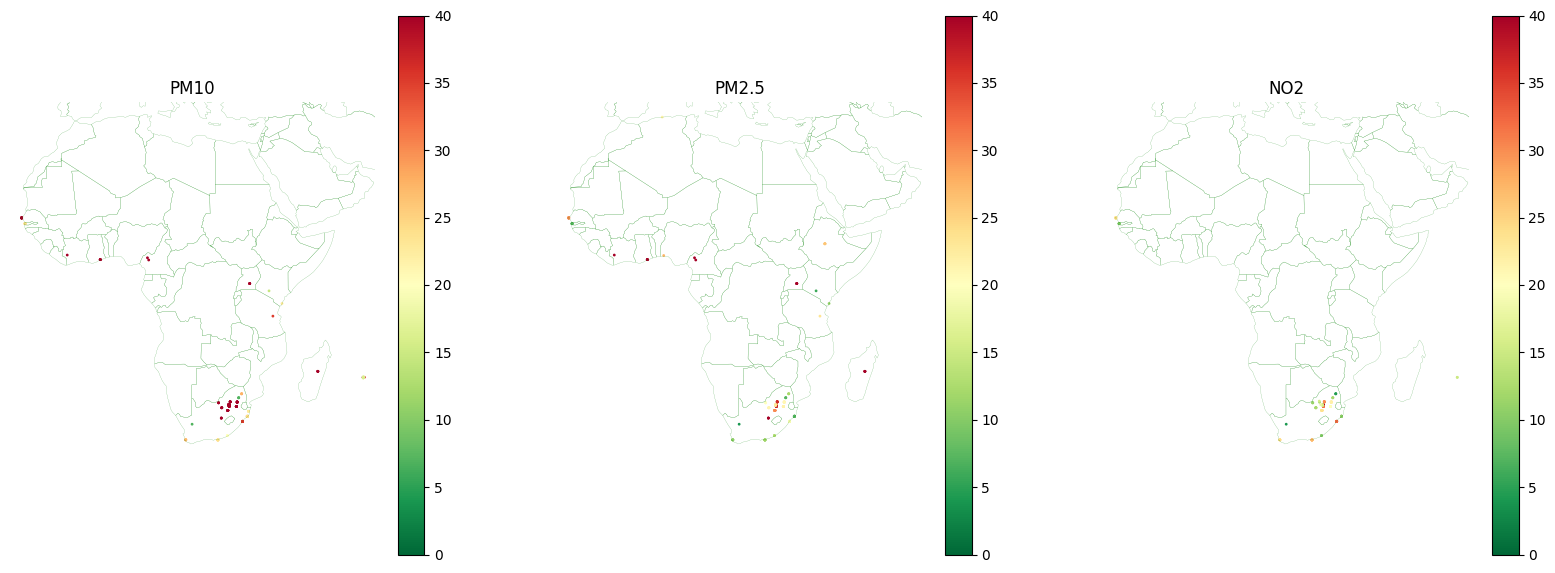

In [154]:
geometry = gpd.points_from_xy(coord_df_AfricanRegion['long'], coord_df_AfricanRegion['lat'])

gdf = gpd.GeoDataFrame(coord_df_AfricanRegion, geometry=geometry)

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

gdf.plot(ax=axes[0], column='Avg_PM10', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[0], linewidth=0.1, color="green")
axes[0].set_title('PM10')
axes[0].set_axis_off()
axes[0].set_xlim([-20, 60])
axes[0].set_ylim([-40, 40])


gdf.plot(ax=axes[1], column='Avg_PM2.5', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[1], linewidth=0.1, color="green")
axes[1].set_title('PM2.5')
axes[1].set_axis_off()
axes[1].set_xlim([-20, 60])
axes[1].set_ylim([-40, 40])

gdf.plot(ax=axes[2], column='Avg_NO2', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[2], linewidth=0.1, color="green")
axes[2].set_title('NO2')
axes[2].set_axis_off()
axes[2].set_xlim([-20, 60])
axes[2].set_ylim([-40, 40])

plt.show()

Bliski Wschód

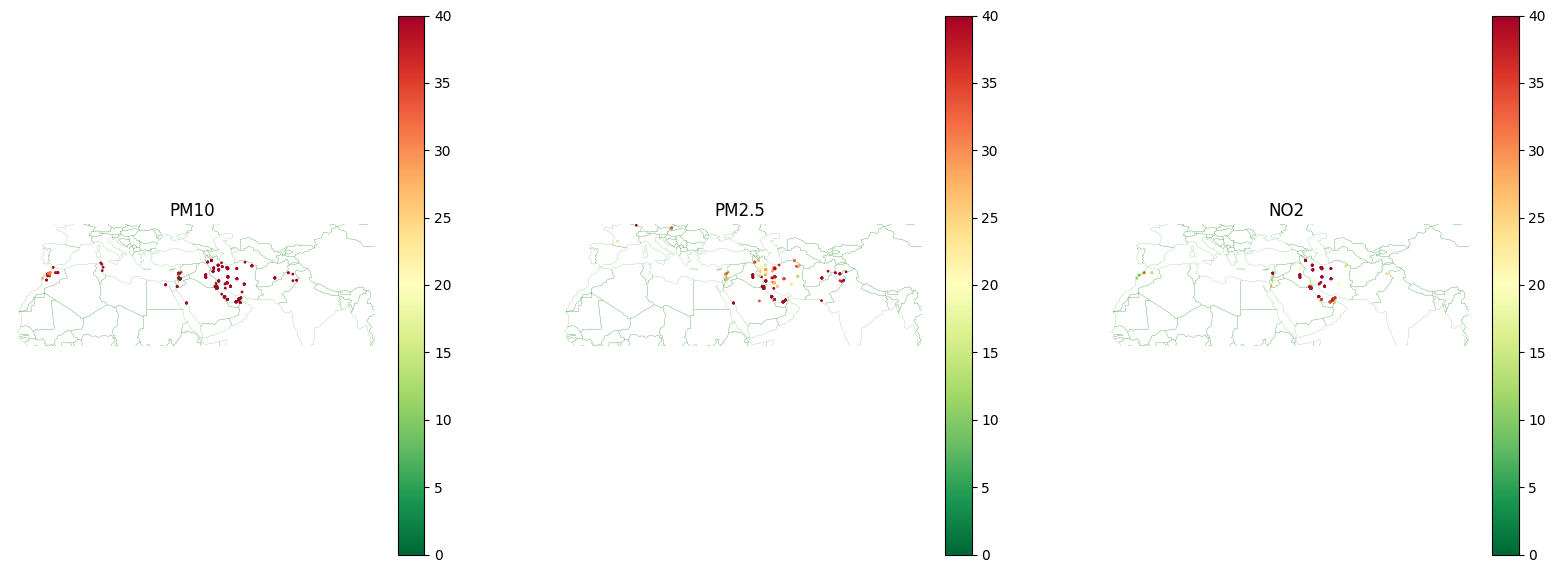

In [160]:
geometry = gpd.points_from_xy(coord_df_EasternMediterraneanRegion['long'], coord_df_EasternMediterraneanRegion['lat'])

gdf = gpd.GeoDataFrame(coord_df_EasternMediterraneanRegion, geometry=geometry)

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

gdf.plot(ax=axes[0], column='Avg_PM10', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[0], linewidth=0.1, color="green")
axes[0].set_title('PM10')
axes[0].set_axis_off()
axes[0].set_xlim([-20, 100])
axes[0].set_ylim([10, 50])


gdf.plot(ax=axes[1], column='Avg_PM2.5', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[1], linewidth=0.1, color="green")
axes[1].set_title('PM2.5')
axes[1].set_axis_off()
axes[1].set_xlim([-20, 100])
axes[1].set_ylim([10, 50])

gdf.plot(ax=axes[2], column='Avg_NO2', cmap="RdYlGn_r", legend=True, markersize=1,vmin=0, vmax=40)
world.boundary.plot(ax=axes[2], linewidth=0.1, color="green")
axes[2].set_title('NO2')
axes[2].set_axis_off()
axes[2].set_xlim([-20, 100])
axes[2].set_ylim([10, 50])

plt.show()

# Wnioski
Pierwszym nasuwającym się wnioskiem jest duża ilość wartości brakujących. Moim zdaniem te dane nie są zbyt użyteczne przez to - ciężko uzupełniać wartości brakujące, gdy tak dominują zbiór danych. Przykładowo w kolumnie PM10 temporal coverage (%) 83% danych to wartości brakujące. Osobiście nie zdecydowałam się ich uzupełniać, ponieważ na potrzeby tego projektu nie uważam by to miało większy sens. Do badań zanieczyszczenia powietrza warto użyć jakiegoś innego źródła danych lub uzupełnić te bazując na innych zbiorach danych. W przypadku krajów o wyższym stopniu rozwoju, poszczególne kolumny zawierają dane w większej liczbie wierszy. Może to wynikać z faktu, że kraje bardziej rozwinięte prowadzą bardziej dokładne rejestracje emisji zanieczyszczeń. 
W Europie oraz Amerykach zdecydowanie polepsza się jakość powietrza na przestrzeni lat. Tego nie można powiedzieć za to o Afryce. Półwysep Arabski odnotowuje bardzo wysokie zanieczyszczenia powietrza, podobnie jak kraje azjatyckie o bardzo dużej gęstości zaludnienia i intensywnej działalności przemysłowej. Pomimo rosnącej świadomości ekologicznej, nadal są miejsca, gdzie nie zwraca się uwagi na działania zapobiegające zjawisku zanieczyszczenia powietrza.